In [97]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from xgboost import XGBClassifier

import warnings
pd.options.display.max_colwidth = 200
warnings.filterwarnings(action='ignore')

# Exploratory data analysis (EDA) - hp_retro_data, continuous data version
Precise descriptions of the data are available in the doc and xls files

In [98]:
hp_retro_df = pd.read_excel('./hp_retro_data.xls', sheet_name='Continouos Data (Final)', skiprows=2)
hp_retro_df.head()

,NUMBER,SEX,TEMP,HEART_RATE,AGE,PREV_VISIT,HX_TRAUMA,COMPLAINT_SITE,HX_ILLNESS,GAIT_REPORTED,...,GAIT_OBSERVED,PAIN_ROM_HIP,OTHER_PAIN_SITE,PAIN_PALPATION,SWELLING,CURRENT_ILLNESS,PREV_PROBLEMS,WBC,ESR,TRIAGE
0,1,FEMALE,?,96,12.679452,?,NO,HIP,NO,NOT_WT_BEAR,...,?,YES,?,TENDER,NO,NO,NO,?,?,DISCHARGE
1,3,FEMALE,37.6,126,2.572603,?,NO,LEG,NO,?,...,?,YES,NO,?,?,NO,NO,?,?,DISCHARGE
2,4,MALE,35.9,?,15.569863,?,?,HIP,NO,?,...,LIMP,YES,NO,?,NO,YES,?,?,?,DISCHARGE
3,5,MALE,36.3,80,16.758904,?,YES,HIP,?,?,...,NORMAL,YES,?,NORMAL,NO,NO,?,?,?,DISCHARGE
4,7,FEMALE,?,88,15.186301,?,YES,HIP,?,?,...,NOT_WT_BEAR,?,LEG,?,NO,?,NO,?,?,DISCHARGE


In [99]:
hp_retro_df.replace('?', np.NaN, inplace=True)
hp_retro_df['HEART_RATE'] = hp_retro_df['HEART_RATE'].astype('Int64')

In [4]:
hp_retro_df.sample(10)

,NUMBER,SEX,TEMP,HEART_RATE,AGE,PREV_VISIT,HX_TRAUMA,COMPLAINT_SITE,HX_ILLNESS,GAIT_REPORTED,...,GAIT_OBSERVED,PAIN_ROM_HIP,OTHER_PAIN_SITE,PAIN_PALPATION,SWELLING,CURRENT_ILLNESS,PREV_PROBLEMS,WBC,ESR,TRIAGE
257,307,MALE,NaN,<NA>,6.726027,NaN,NaN,HIP,NO,NaN,...,LIMP,YES,NO,NORMAL,NO,NO,YES,6.81,16.0,DISCHARGE
329,279,MALE,NaN,86,3.430137,YES,YES,LEG,NO,NOT_WT_BEAR,...,NOT_WT_BEAR,NaN,NO,NaN,NaN,NO,NO,NaN,NaN,XRAY
64,92,FEMALE,36.5,96,6.641096,NaN,NaN,HIP,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DISCHARGE
323,112,MALE,36.9,92,5.019178,YES,NO,LEG,NO,LIMP,...,NORMAL,NaN,NaN,NORMAL,NO,NO,NO,NaN,NaN,XRAY
253,303,MALE,NaN,121,2.358904,NaN,NO,NaN,YES,LIMP,...,LIMP,NO,NO,NORMAL,NO,YES,NO,8.88,7.0,DISCHARGE
123,157,MALE,37.2,96,3.323288,NaN,YES,LEG,NO,LIMP,...,LIMP,YES,NO,NaN,NaN,NO,NO,10.40,2.0,DISCHARGE
174,213,FEMALE,36.4,118,1.605479,YES,NO,LEG,NO,NOT_WT_BEAR,...,NOT_WT_BEAR,NO,NO,TENDER,NO,YES,NO,NaN,NaN,DISCHARGE
36,57,MALE,36.8,88,10.542466,NaN,NO,LEG,NO,LIMP,...,LIMP,NO,LEG,NORMAL,NO,YES,NO,6.63,24.0,DISCHARGE
167,206,MALE,NaN,<NA>,2.471233,NaN,YES,HIP,NaN,LIMP,...,LIMP,NO,NO,NORMAL,NaN,NaN,NO,NaN,NaN,DISCHARGE
239,285,MALE,36.0,114,2.789041,NaN,NO,LEG,NO,LIMP,...,LIMP,NO,NaN,NORMAL,NO,NO,NO,NaN,NaN,DISCHARGE


In [5]:
hp_retro_df.shape

(412, 26)

In [6]:
hp_retro_df.dtypes
hp_retro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   NUMBER           412 non-null    int64  
 1   SEX              412 non-null    object 
 2   TEMP             332 non-null    float64
 3   HEART_RATE       385 non-null    Int64  
 4   AGE              412 non-null    float64
 5   PREV_VISIT       133 non-null    object 
 6   HX_TRAUMA        318 non-null    object 
 7   COMPLAINT_SITE   405 non-null    object 
 8   HX_ILLNESS       367 non-null    object 
 9   GAIT_REPORTED    356 non-null    object 
 10  DURATION         401 non-null    float64
 11  APPEARANCE       333 non-null    object 
 12  HIP_REST         73 non-null     object 
 13  HIP_ROM          375 non-null    object 
 14  HIP_INT_ROT      341 non-null    object 
 15  HIP_FLEXION      331 non-null    object 
 16  GAIT_OBSERVED    290 non-null    object 
 17  PAIN_ROM_HIP    

## Features types
Continuous:
* TEMP (float)
* HEART_RATE (int)
* AGE (float)
* DURATION (float)
* WBC (float)
* WSR (float)

Categorical:
* SEX
* PREV_VISIT
* HX_TRAUMA
* COMPLAINT_STATE
* HX_ILLNESS
* GAIT_REPORTED
* APPEARANCE
* HIP_REST
* HIP_ROM
* HIP_INT_ROT
* HIP_FLEXION
* GAIT_OBSERVED
* PAIN_ROM_HIP
* OTHER_PAIN_SITE
* PAIN_PALPATION
* SWELLING
* CURRENT_ILLNESS
* PREV_PROBLEMS

Target variable is *TRIAGE* which takes values of *lab_xray_bscan* for positive class label and *xlab*, *discharge* for negative class - the goal is to build binary classifier.

## Data Cleaning

In [7]:
include = ['object', 'float', 'int']
hp_retro_df.describe(include=include)

,NUMBER,SEX,TEMP,HEART_RATE,AGE,PREV_VISIT,HX_TRAUMA,COMPLAINT_SITE,HX_ILLNESS,GAIT_REPORTED,...,GAIT_OBSERVED,PAIN_ROM_HIP,OTHER_PAIN_SITE,PAIN_PALPATION,SWELLING,CURRENT_ILLNESS,PREV_PROBLEMS,WBC,ESR,TRIAGE
count,412.000000,412,332.000000,385.0,412.000000,133,318,405,367,356,...,290,332,293,292,262,361,290,171.000000,162.000000,412
unique,NaN,2,NaN,<NA>,NaN,2,2,4,2,3,...,3,3,5,2,3,4,2,NaN,NaN,3
top,NaN,MALE,NaN,<NA>,NaN,YES,NO,HIP,NO,LIMP,...,LIMP,YES,NO,NORMAL,NO,NO,NO,NaN,NaN,DISCHARGE
freq,NaN,267,NaN,<NA>,NaN,118,253,213,274,179,...,144,180,227,181,257,240,249,NaN,NaN,312
mean,207.410194,NaN,36.997892,102.706494,6.325771,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.044444,22.209877,NaN
std,119.220417,NaN,0.902445,20.053044,4.137247,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.239448,14.236002,NaN
min,1.000000,NaN,34.100000,50.0,1.043836,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.250000,1.000000,NaN
25%,104.750000,NaN,36.400000,88.0,2.817123,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.495000,11.000000,NaN
50%,207.500000,NaN,36.900000,100.0,5.150685,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.880000,18.000000,NaN
75%,310.250000,NaN,37.400000,116.0,9.158904,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.800000,30.000000,NaN


In [5]:
# Get count of missing values in the dataset
nans = pd.DataFrame(hp_retro_df.isna().sum(), columns=['nan count'])
nans['nan %'] = round(hp_retro_df.isna().sum() / len(hp_retro_df) * 100.0, 1)
nans.sort_values(by='nan %', ascending=False)

,nan count,nan %
HIP_REST,339,82.3
PREV_VISIT,279,67.7
ESR,250,60.7
WBC,241,58.5
SWELLING,150,36.4
GAIT_OBSERVED,122,29.6
PREV_PROBLEMS,122,29.6
PAIN_PALPATION,120,29.1
OTHER_PAIN_SITE,119,28.9
HX_TRAUMA,94,22.8


Based on the above information I can get rid of the features which have over 70% missing values (*HIP_REST*). Also the *NUMBER* column doesn't provide any useful information about contexto of the data and can be dropped.

In [100]:
del hp_retro_df['NUMBER'], hp_retro_df['HIP_REST'] 
print('NUMBER and HIP_REST columns dropped')

NUMBER and HIP_REST columns dropped


Get rid of redundant labels for all categorical columns

In [101]:
hp_retro_cat = hp_retro_df.select_dtypes('object')

hp_retro_df[hp_retro_cat.columns] = hp_retro_cat.apply(lambda x: x.str.strip())

Unique values of categorical columns.

In [102]:
for col in hp_retro_df.select_dtypes(exclude=['int', 'float']).columns:
    print(hp_retro_df[col].unique())
    print(hp_retro_df[col].value_counts())

['FEMALE' 'MALE']
SEX
MALE      267
FEMALE    145
Name: count, dtype: int64
[nan 'YES' 'NO']
PREV_VISIT
YES    118
NO      15
Name: count, dtype: int64
['NO' nan 'YES']
HX_TRAUMA
NO     253
YES     65
Name: count, dtype: int64
['HIP' 'LEG' nan 'OTHER' 'BACK']
COMPLAINT_SITE
HIP      213
LEG      185
OTHER      5
BACK       2
Name: count, dtype: int64
['NO' nan 'YES']
HX_ILLNESS
NO     274
YES     93
Name: count, dtype: int64
['NOT_WT_BEAR' nan 'NORMAL' 'LIMP']
GAIT_REPORTED
LIMP           179
NOT_WT_BEAR    166
NORMAL          11
Name: count, dtype: int64
['WELL_NAD' nan 'DISTRESS_UNWELL']
APPEARANCE
WELL_NAD           303
DISTRESS_UNWELL     30
Name: count, dtype: int64
['DECREASED' 'NORMAL' nan]
HIP_ROM
NORMAL       215
DECREASED    160
Name: count, dtype: int64
['DECREASED' 'NORMAL' nan]
HIP_INT_ROT
NORMAL       246
DECREASED     95
Name: count, dtype: int64
['NORMAL' 'DECREASED' nan]
HIP_FLEXION
NORMAL       259
DECREASED     72
Name: count, dtype: int64
[nan 'LIMP' 'NORMAL' 'NOT_W

Filling in missing values using mean for numerical features and most-frequent values for categorical columns.

In [103]:
# Get columns with null values
print("Columns with null values before imputing")
print(hp_retro_df.columns[hp_retro_df.isna().any()].tolist())

for col in hp_retro_df.columns:
    imp = SimpleImputer(missing_values=np.NaN, strategy="most_frequent" if hp_retro_df[col].dtype == "O" else "mean")
    imp = imp.fit(hp_retro_df[[col]])
    hp_retro_df[col] = imp.fit_transform(hp_retro_df[[col]]).reshape(-1)

print("Columns with null values after imputing")
print(hp_retro_df.columns[hp_retro_df.isna().any()].tolist())

Columns with null values before imputing
['TEMP', 'HEART_RATE', 'PREV_VISIT', 'HX_TRAUMA', 'COMPLAINT_SITE', 'HX_ILLNESS', 'GAIT_REPORTED', 'DURATION', 'APPEARANCE', 'HIP_ROM', 'HIP_INT_ROT', 'HIP_FLEXION', 'GAIT_OBSERVED', 'PAIN_ROM_HIP', 'OTHER_PAIN_SITE', 'PAIN_PALPATION', 'SWELLING', 'CURRENT_ILLNESS', 'PREV_PROBLEMS', 'WBC', 'ESR']
Columns with null values after imputing
[]


### Binarize target class

In [104]:
hp_retro_df["TRIAGE"] = hp_retro_df["TRIAGE"].replace(["DISCHARGE", "XRAY"], "DISCHARGE/XRAY")

In [105]:
categorical_features = [c for c in hp_retro_df.columns if hp_retro_df[c].dtype == "O" and c != "TRIAGE"]
numerical_features = [c for c in hp_retro_df.columns if c not in categorical_features and c != "TRIAGE"]
print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['SEX', 'PREV_VISIT', 'HX_TRAUMA', 'COMPLAINT_SITE', 'HX_ILLNESS', 'GAIT_REPORTED', 'APPEARANCE', 'HIP_ROM', 'HIP_INT_ROT', 'HIP_FLEXION', 'GAIT_OBSERVED', 'PAIN_ROM_HIP', 'OTHER_PAIN_SITE', 'PAIN_PALPATION', 'SWELLING', 'CURRENT_ILLNESS', 'PREV_PROBLEMS']
Numerical Features: ['TEMP', 'HEART_RATE', 'AGE', 'DURATION', 'WBC', 'ESR']


Plot target class distribution

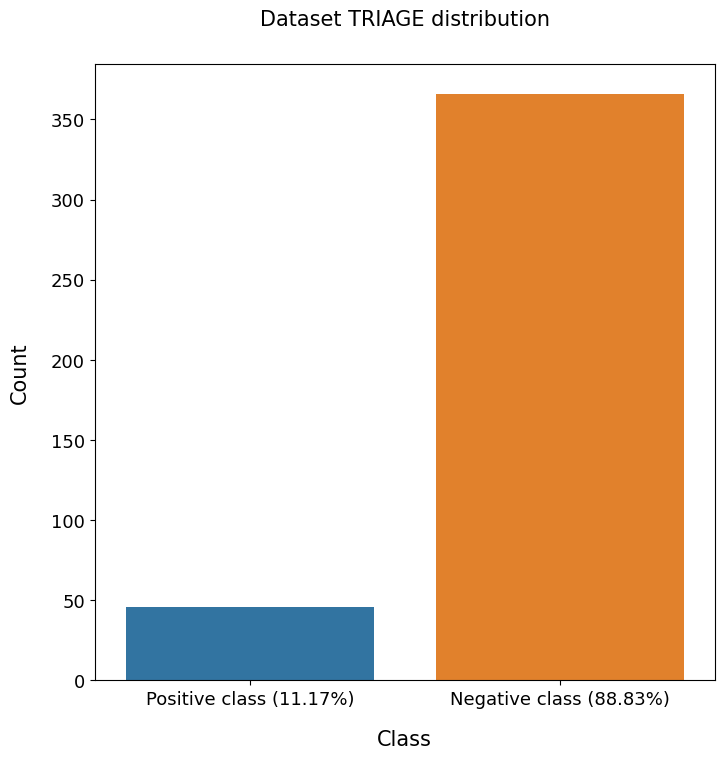

In [36]:
negative = [c for c in hp_retro_df["TRIAGE"].unique() if c != "LAB_XRAY_BSCAN"][0]
positive_class = hp_retro_df["TRIAGE"].value_counts()["LAB_XRAY_BSCAN"]
negative_class = hp_retro_df["TRIAGE"].shape[0] - positive_class
positive_per = positive_class / hp_retro_df.shape[0] * 100
negative_per = negative_class / hp_retro_df.shape[0] * 100
plt.figure(figsize=(8, 8))
sns.countplot(x="TRIAGE", data=hp_retro_df, order=["LAB_XRAY_BSCAN", negative])
plt.xlabel("Class", size=15, labelpad=15)
plt.ylabel("Count", size=15, labelpad=15)
plt.xticks((0, 1), [ 'Positive class ({0:.2f}%)'.format(positive_per), 'Negative class ({0:.2f}%)'.format(negative_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.title("Dataset TRIAGE distribution", size=15, y=1.05)
plt.show()

The classes are imbalanced. The method I will try to tackle this problem is SMOTE in the latter stages of the data analysis.

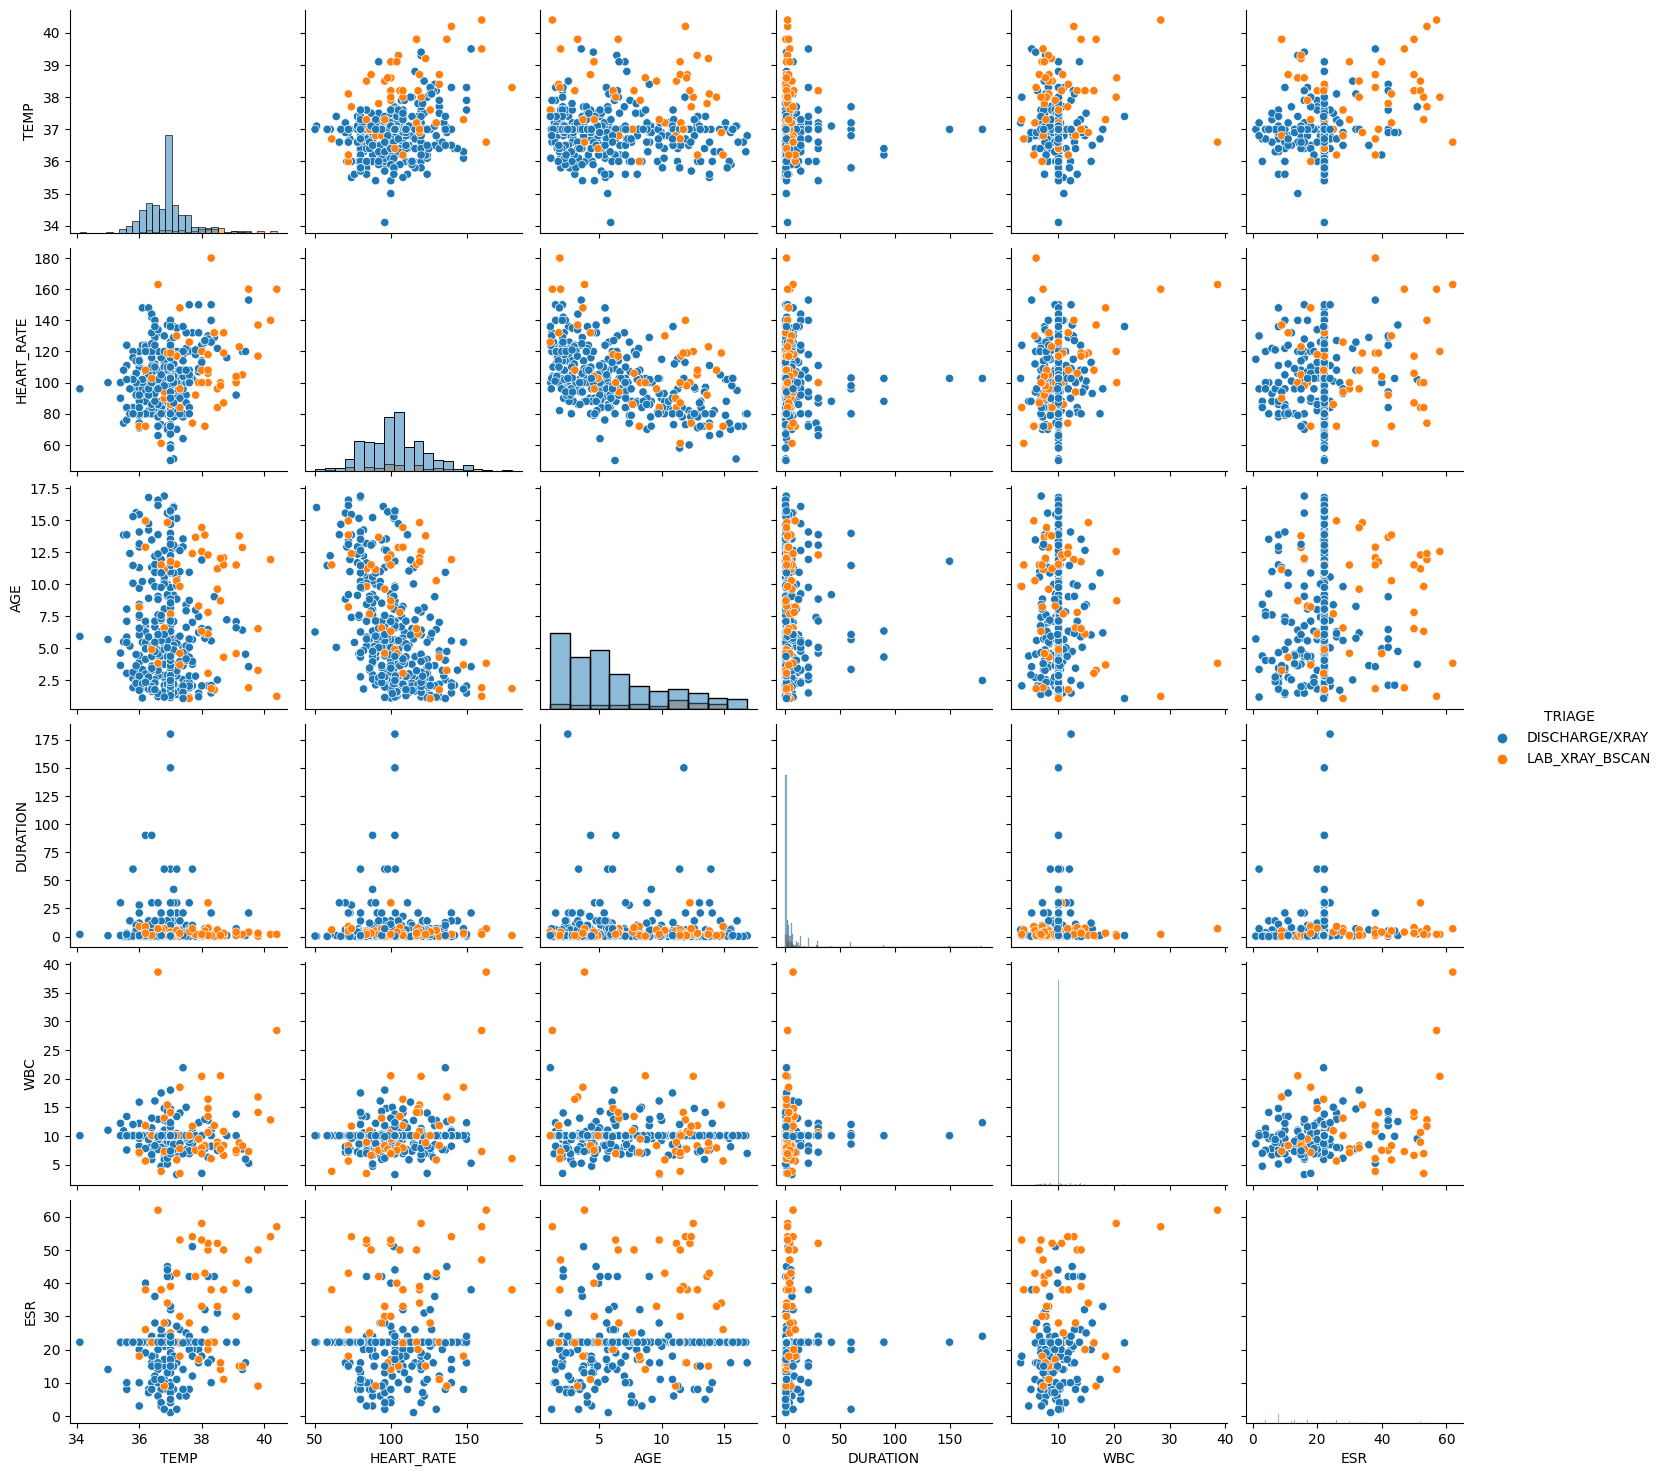

In [37]:
# Pairplots
sns.pairplot(hp_retro_df, diag_kind ='hist', hue="TRIAGE")
plt.show()

Observation: Higher TEMP and ESR values tend to coexist with positive class (LAB_XRAY_BSCAN).

In [38]:
def plot_numeric(data, numeric_features, target):
    """ 
    plots analysing numerical features
    Inputs : 
        data -- dataframe containing features to plot
        numeric_features -- list of numerical features
        target -- target column name
     """
    # Looping through and Plotting Numeric features
    for column in numeric_features:    
        # Figure initiation
        fig = plt.figure(figsize=(18,12))

        ### Distribution plot
        sns.distplot(data[column], ax=plt.subplot(221));
        # X-axis Label
        plt.xlabel(column, fontsize=14);
        # Y-axis Label
        plt.ylabel('Density', fontsize=14);
        # Adding Super Title (One for a whole figure)
        plt.suptitle('Plots for '+column, fontsize=18);

        ### Distribution per Positive / Negative class Value
        # Not Survived hist
        classes = data[target].unique()
        sns.distplot(data.loc[data[target]==classes[0], column].dropna(),
                     color='red', label=str(classes[0]), ax=plt.subplot(222));
        # Survived hist
        sns.distplot(data.loc[data[target]==classes[1], column].dropna(),
                     color='blue', label=str(classes[1]), ax=plt.subplot(222));
        # Adding Legend
        plt.legend(loc='best')
        # X-axis Label
        plt.xlabel(column, fontsize=14);
        # Y-axis Label
        plt.ylabel('Density per '+ str(classes[0])+' / '+str(classes[1]), fontsize=14);

        ### Average Column value per positive / Negative Value
        sns.barplot(x=target, y=column, data=data, ax=plt.subplot(223));
        # X-axis Label
        plt.xlabel('Positive or Negative?', fontsize=14);
        # Y-axis Label
        plt.ylabel('Average ' + column, fontsize=14);

        ### Boxplot of Column per Positive / Negative class Value
        sns.boxplot(x=target, y=column, data=data, ax=plt.subplot(224));
        # X-axis Label
        plt.xlabel('Positive or Negative ?', fontsize=14);
        # Y-axis Label
        plt.ylabel(column, fontsize=14);
        # Printing Chart
        plt.show()
        
def plot_categ(train_data, target, nominal_features,positive =1) :
    """ 
    plots analysing nominal categorical features
    Inputs : 
        data -- dataframe containing features to plot
        nominal_features -- list of nominal features
        target -- target column name
     """
    # Looping through and Plotting Categorical features
    for column in nominal_features:
    # Figure initiation
        fig = plt.figure(figsize=(18,12))
        
        ### Number of occurrences per categoty - target pair
        ax = sns.countplot(x=column, hue=target, data=train_data, ax = plt.subplot(211));
        # X-axis Label
        plt.xlabel(column, fontsize=14);
        # Y-axis Label
        plt.ylabel('Number of occurrences', fontsize=14);
        # Adding Super Title (One for a whole figure)
        plt.suptitle('Plots for '+column, fontsize=18);
        # Setting Legend location 
        plt.legend(loc=1);

        ### Adding percents over bars
        # Getting heights of our bars
        height = [p.get_height() if np.isnan(p.get_height()) == 0 else 0 for p in ax.patches] #  get nan if
        # Counting number of bar groups 
        ncol = int(len(height)/2)
        # Counting total height of groups
        total = [height[i] + height[i + ncol] for i in range(ncol)] * 2
        # Looping through bars
        for i, p in enumerate(ax.patches):    
            # Adding percentages
            ax.text(p.get_x()+p.get_width()/2, height[i]*1.01 + 10,
                    '{:1.0%}'.format(height[i]/total[i]), ha="center", size=14) 

        negative = train_data[target].unique()[0] if train_data[target].unique()[0] != positive else train_data[target].unique()[1]
        ### Positive class percentage for every value of feature
        
        sns.pointplot(x=train_data[column], y=train_data[target].map({negative:0 , positive: 1}), ax = plt.subplot(212));
        # X-axis Label
        plt.xlabel(column, fontsize=14);
        # Y-axis Label
        plt.ylabel(' Positive class percentage', fontsize=14);
        # Printing Chart
        plt.show()

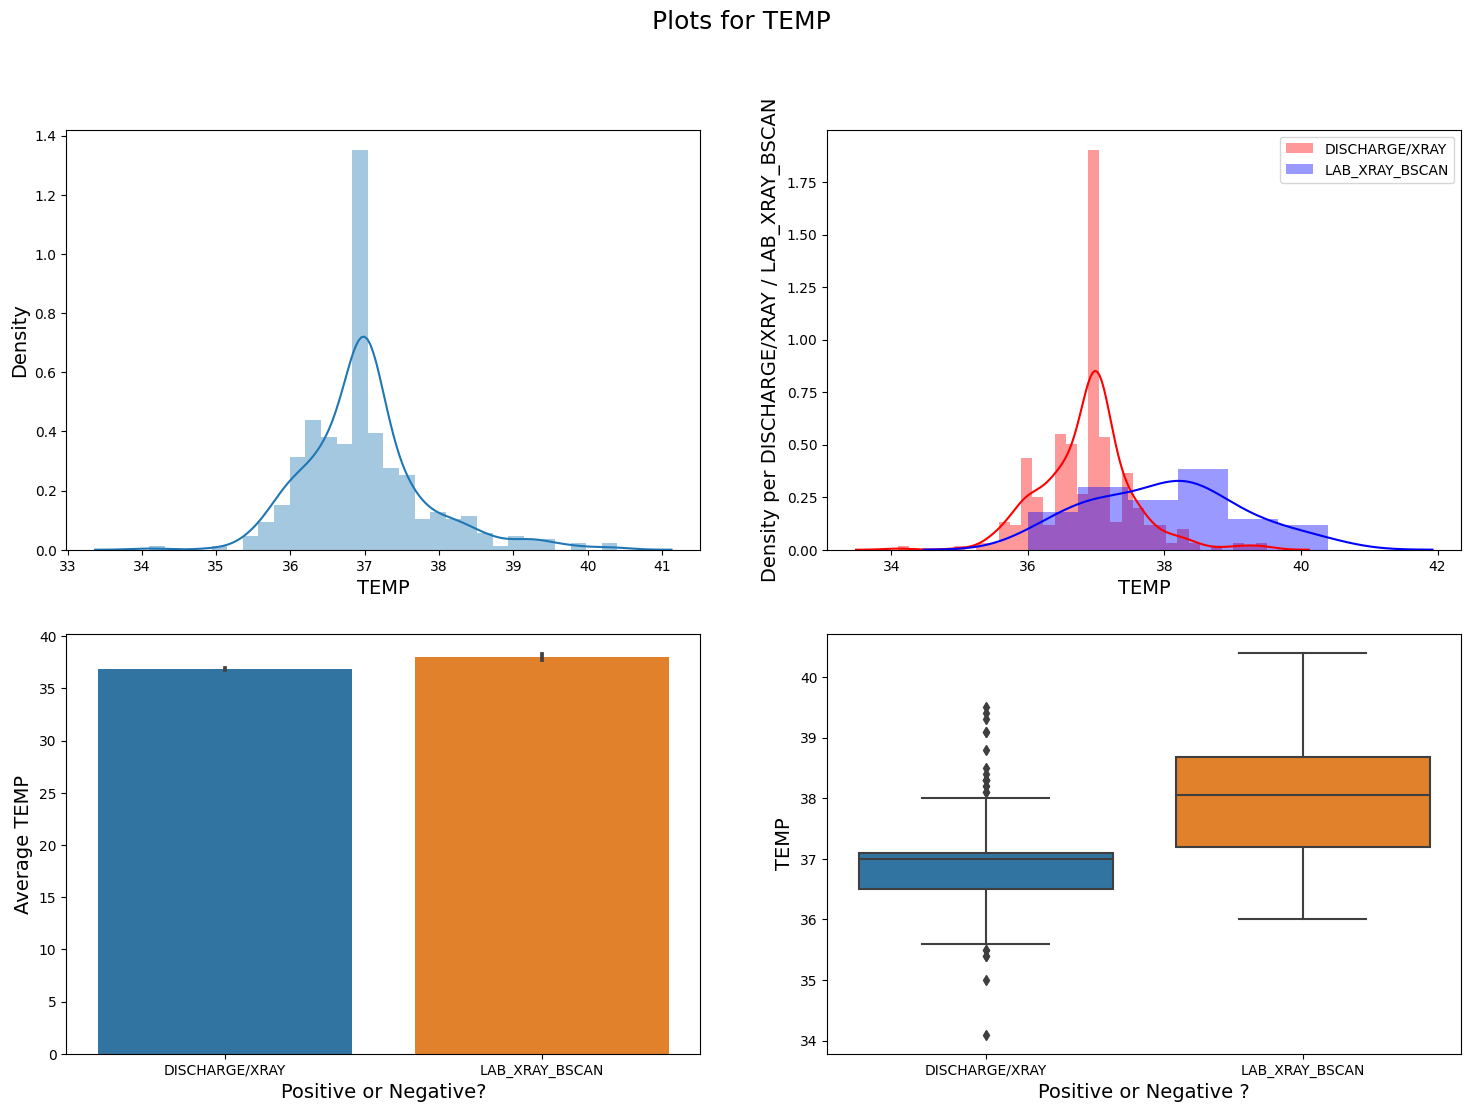

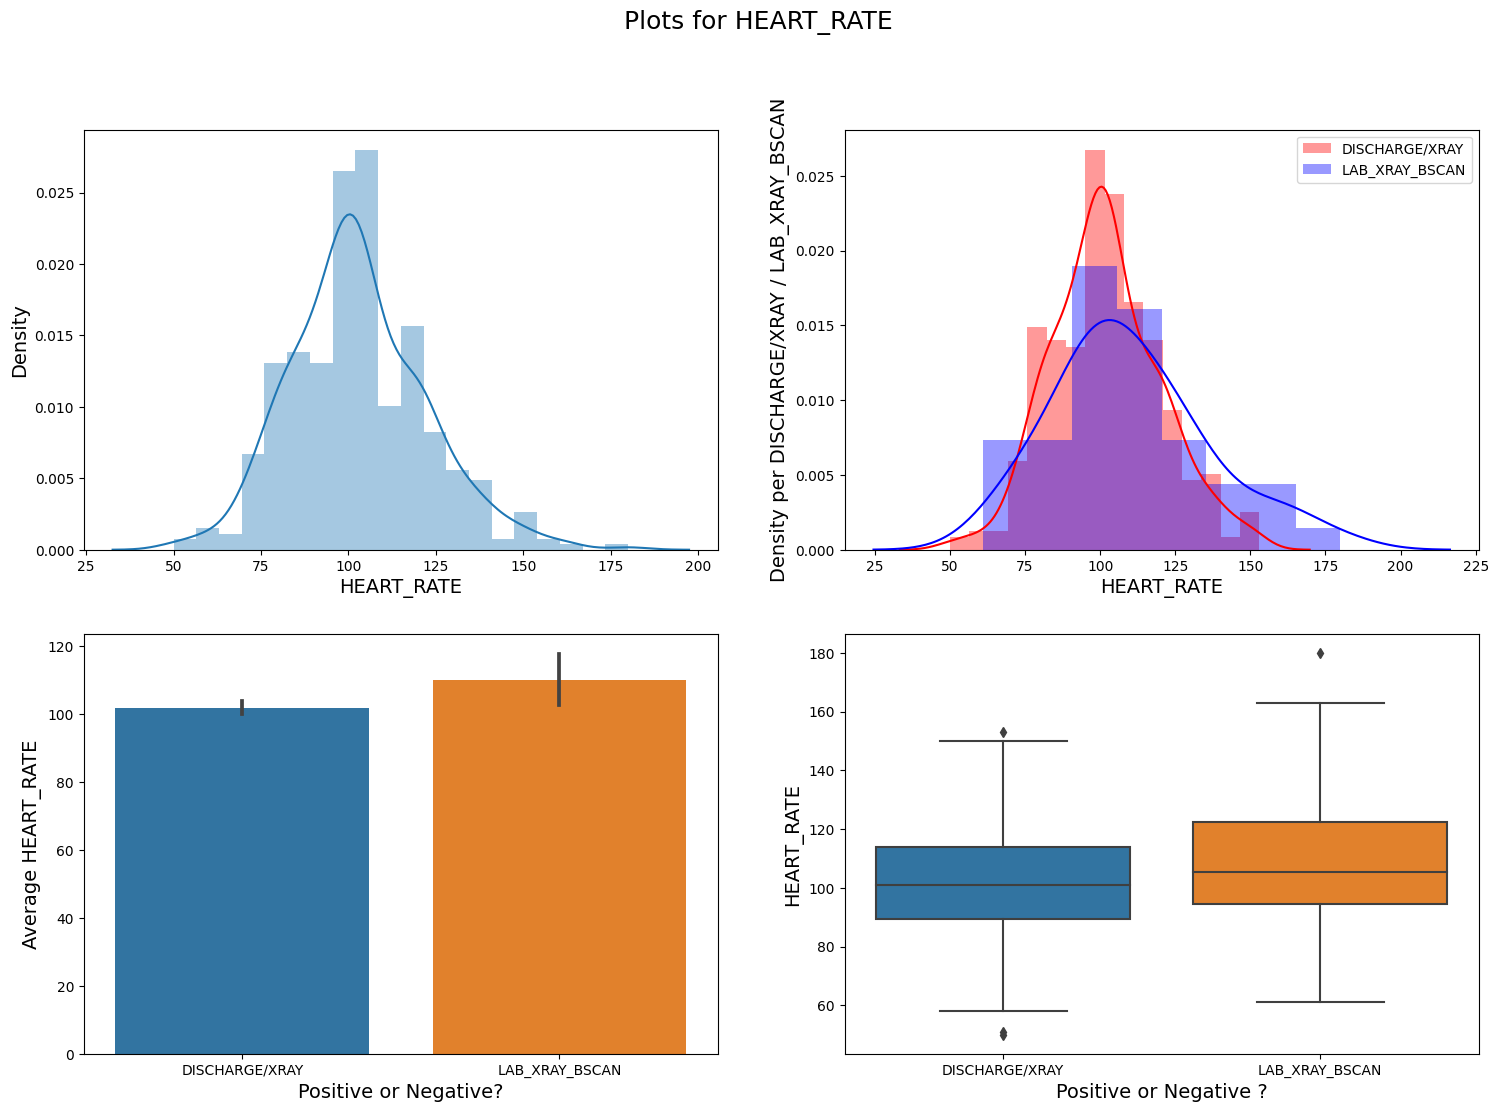

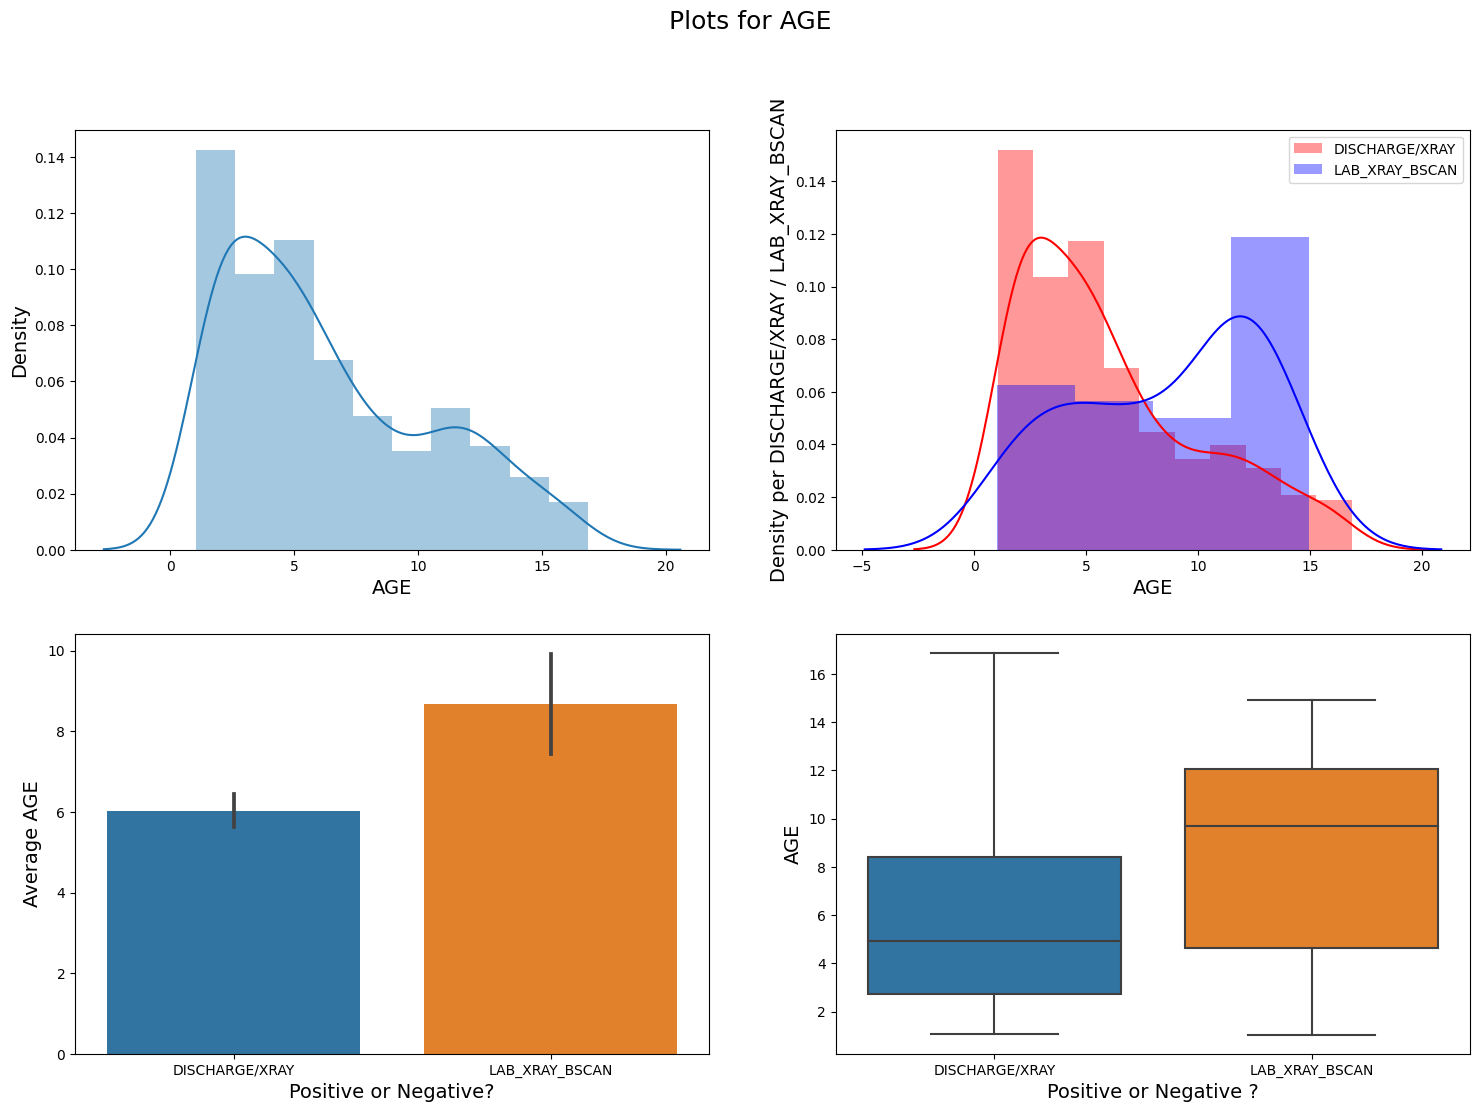

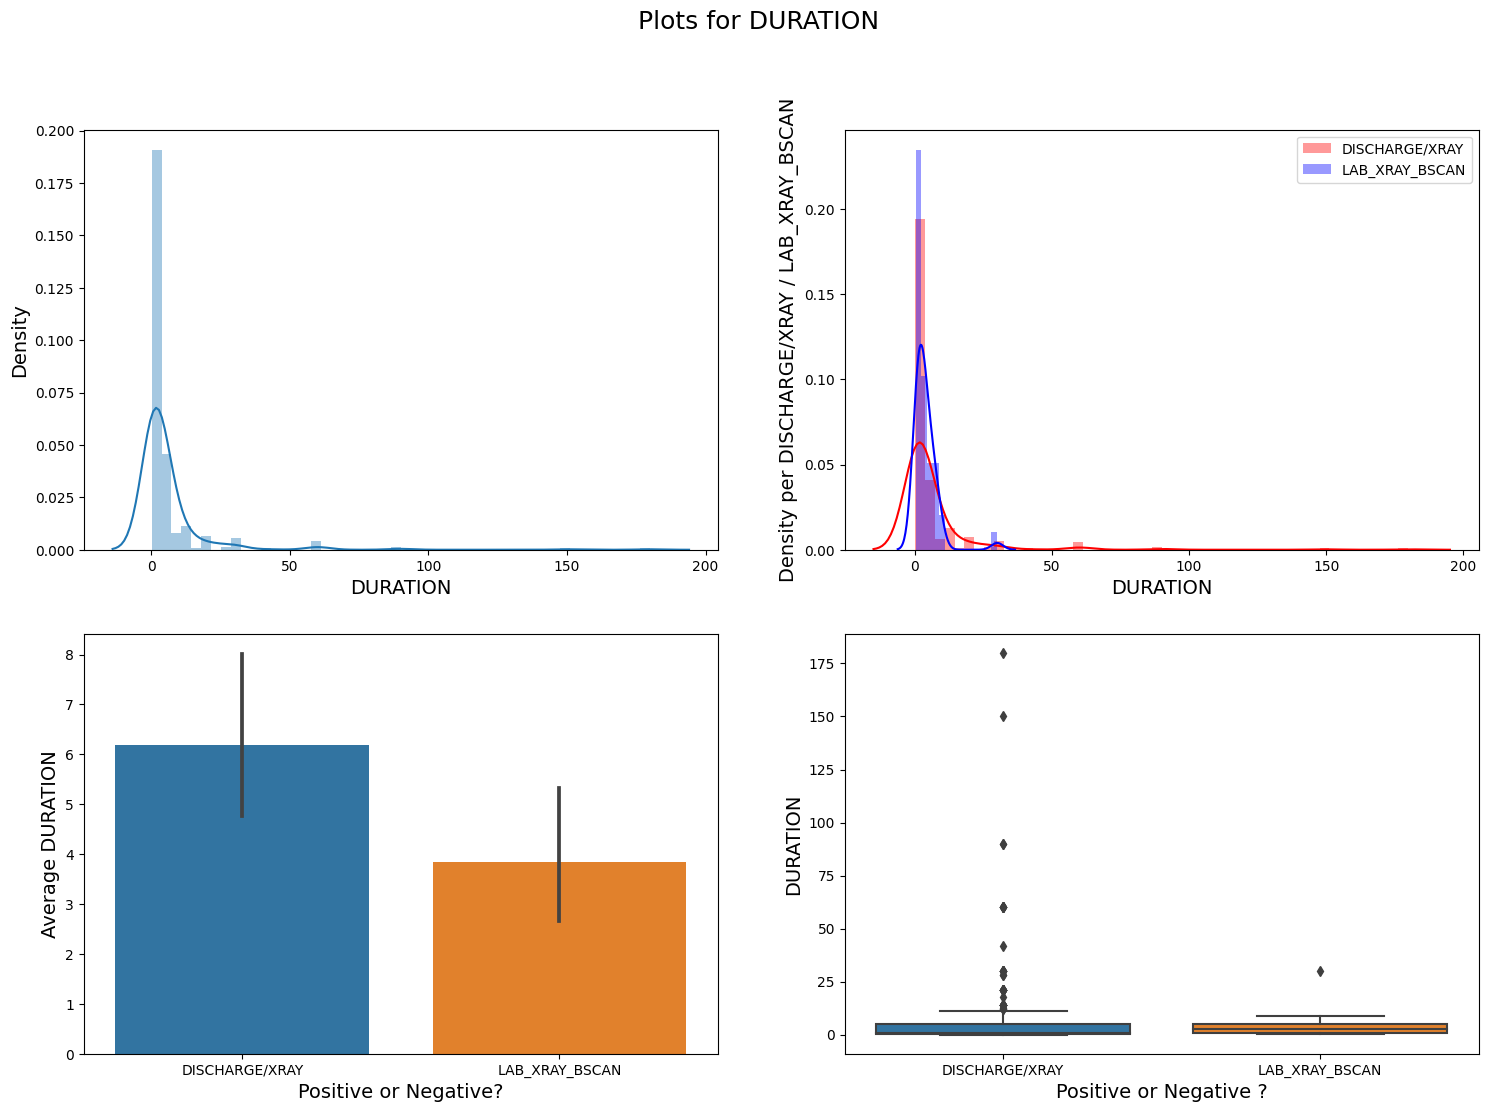

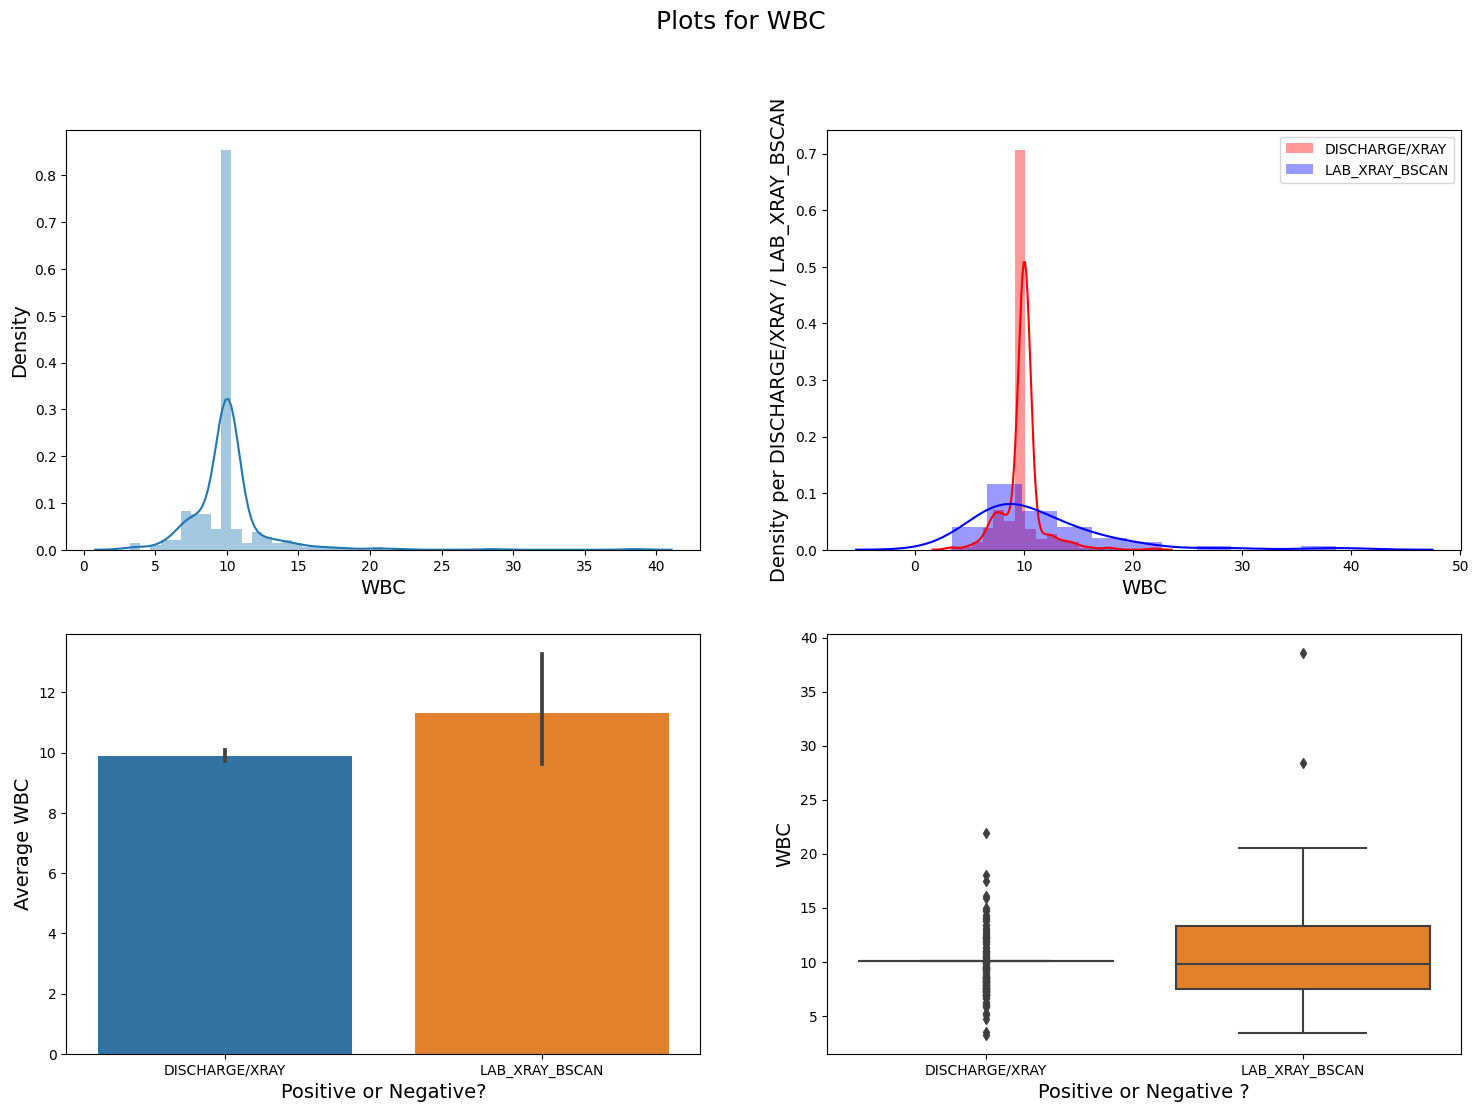

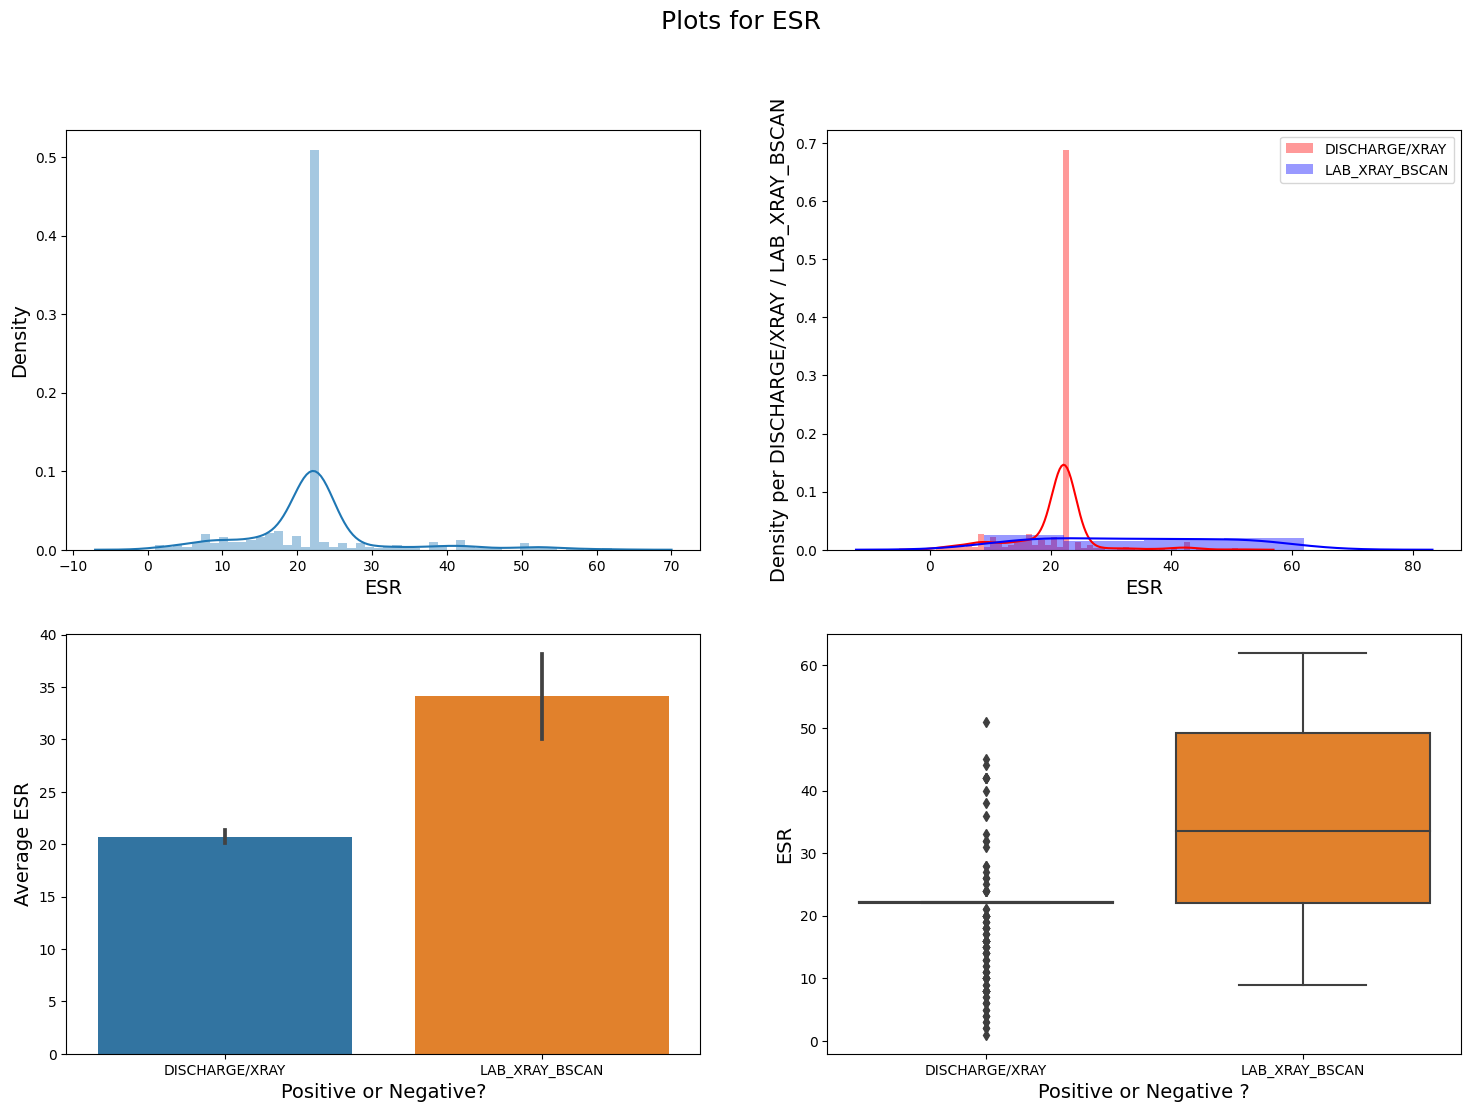

In [39]:
### Plotting Numeric Features
plot_numeric(hp_retro_df, numerical_features, 'TRIAGE')

Some features contain outliers.

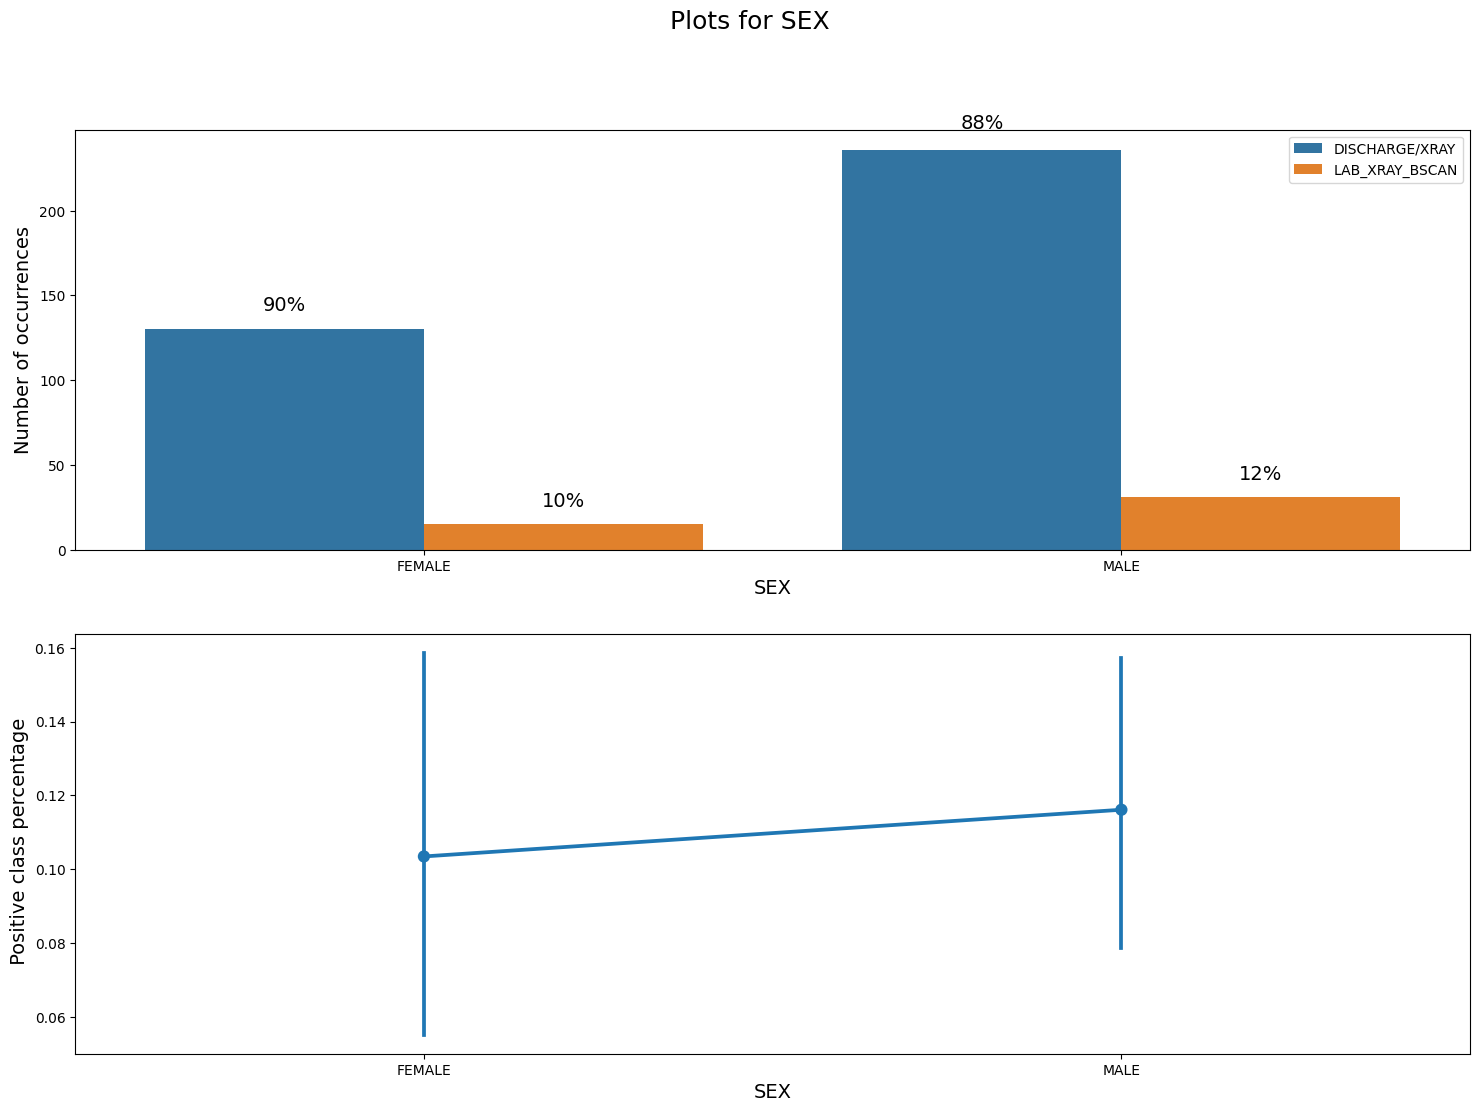

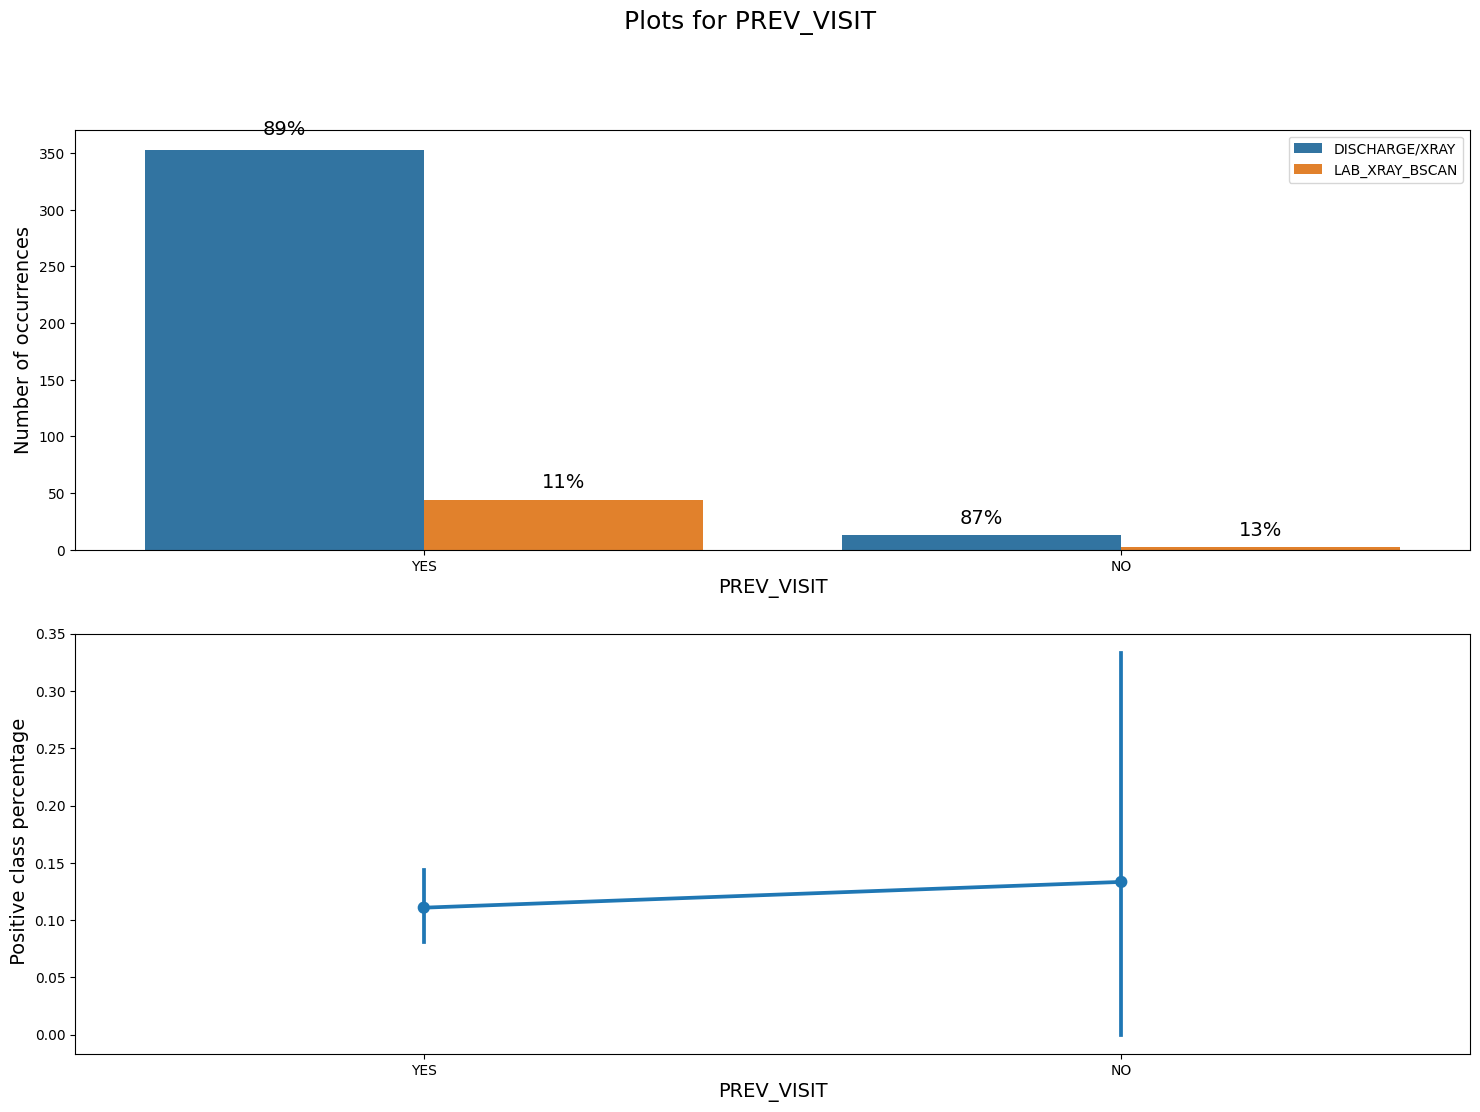

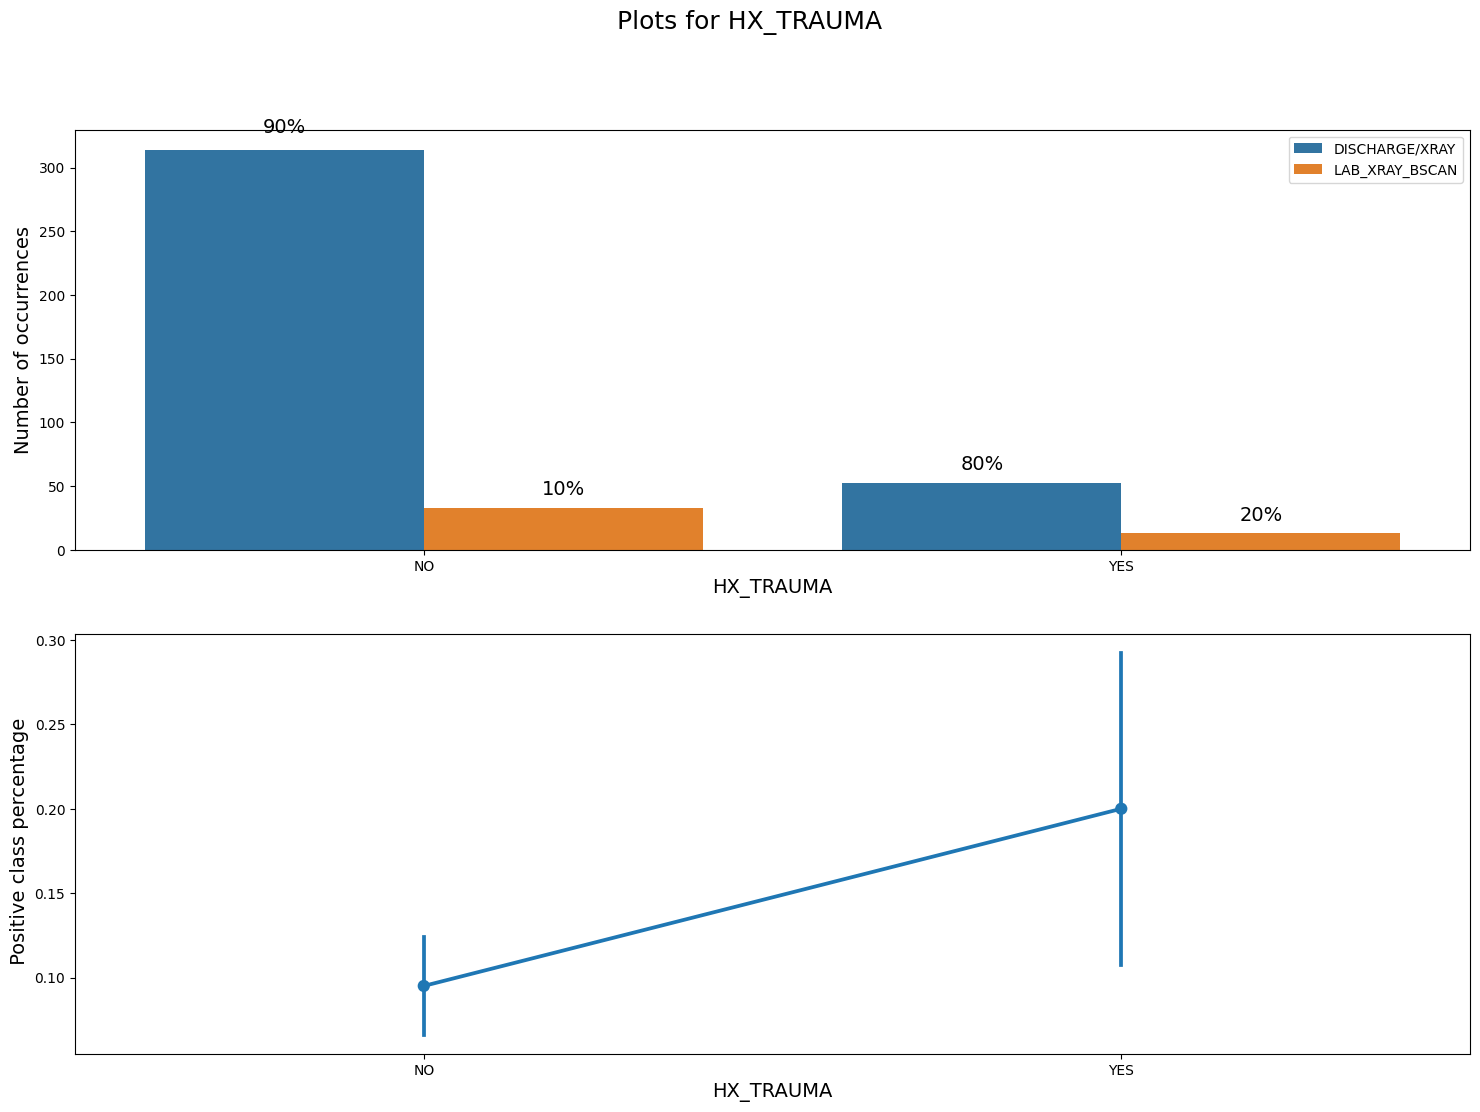

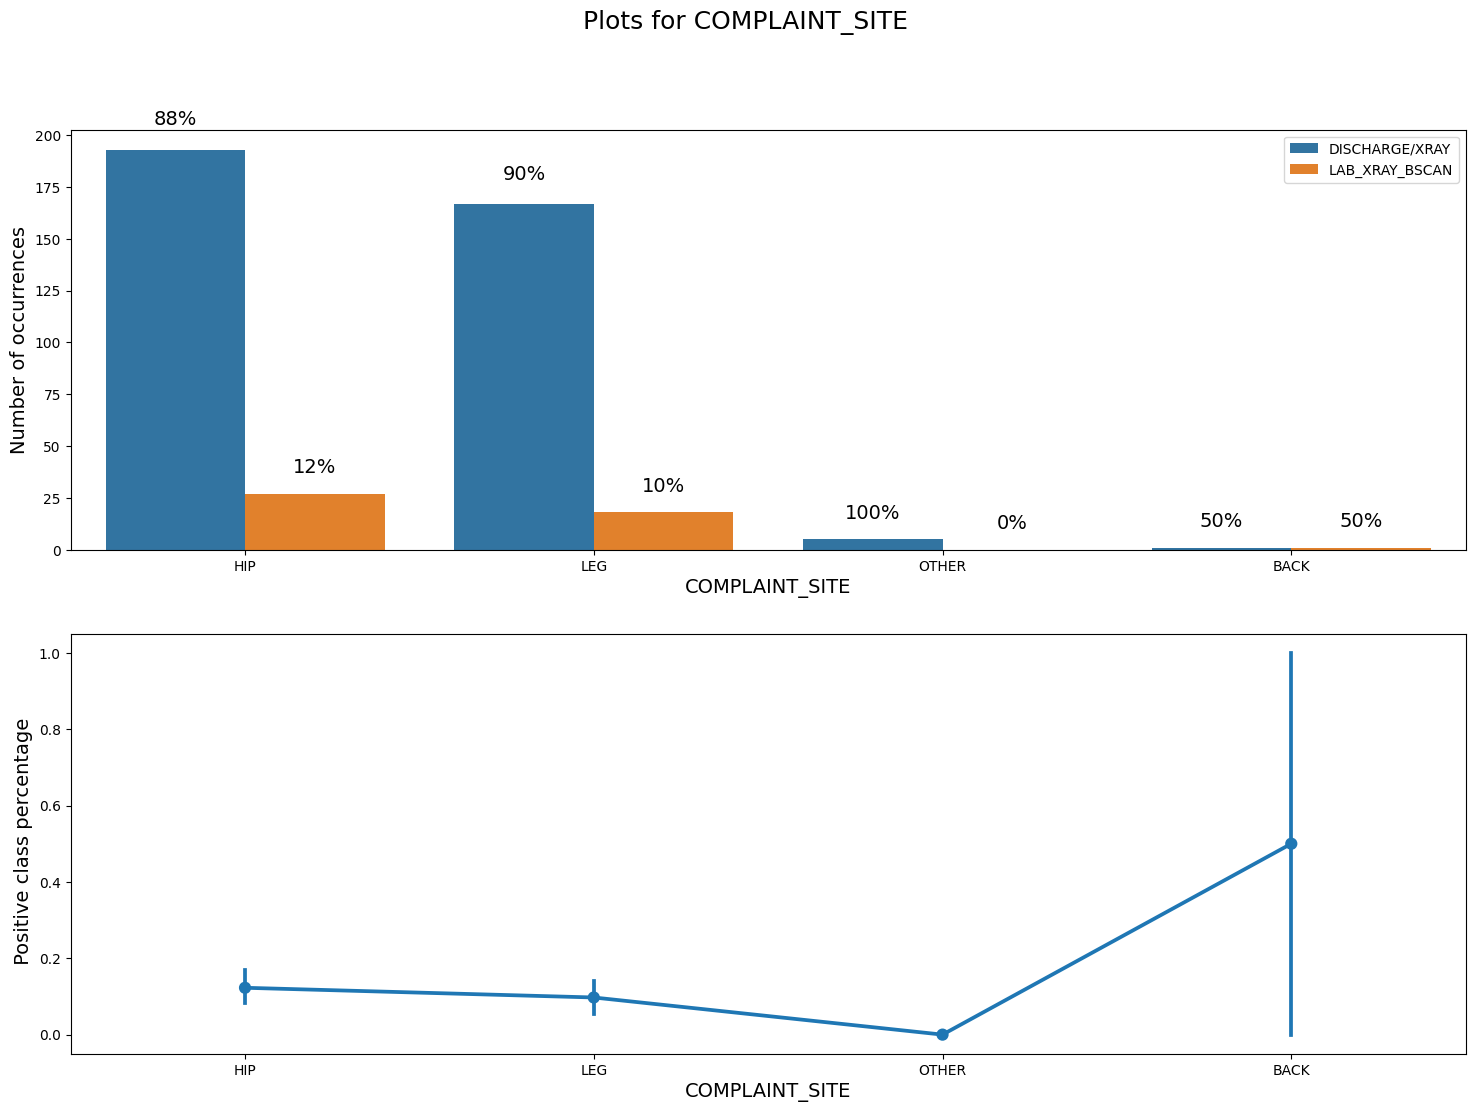

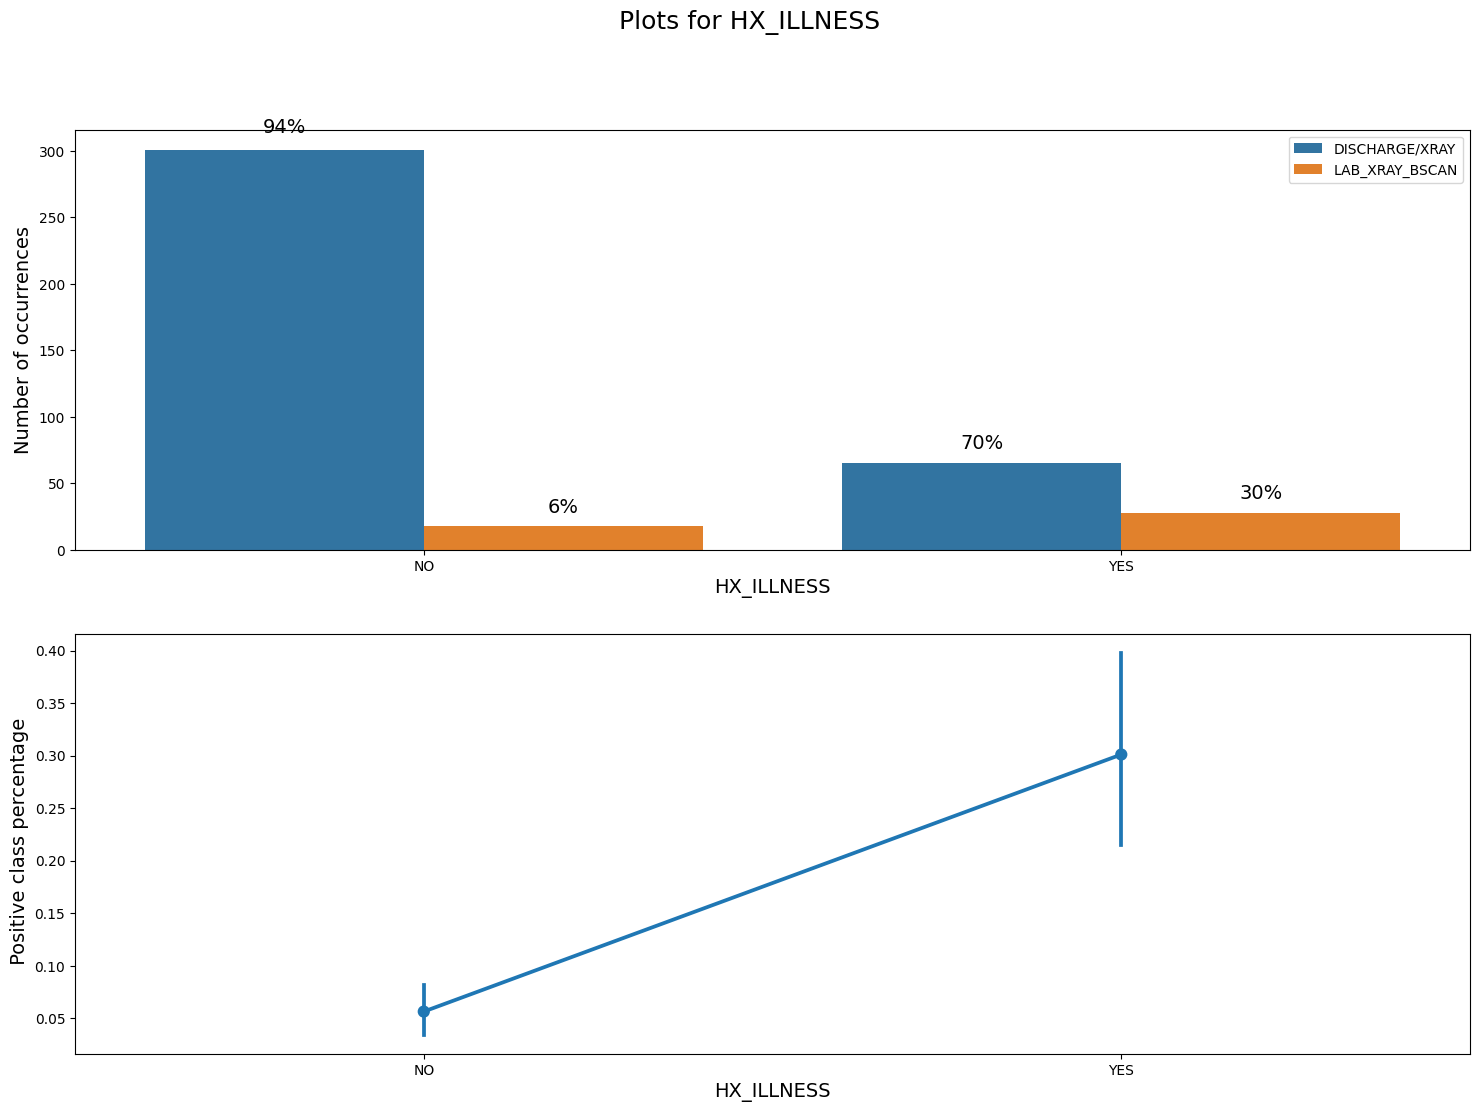

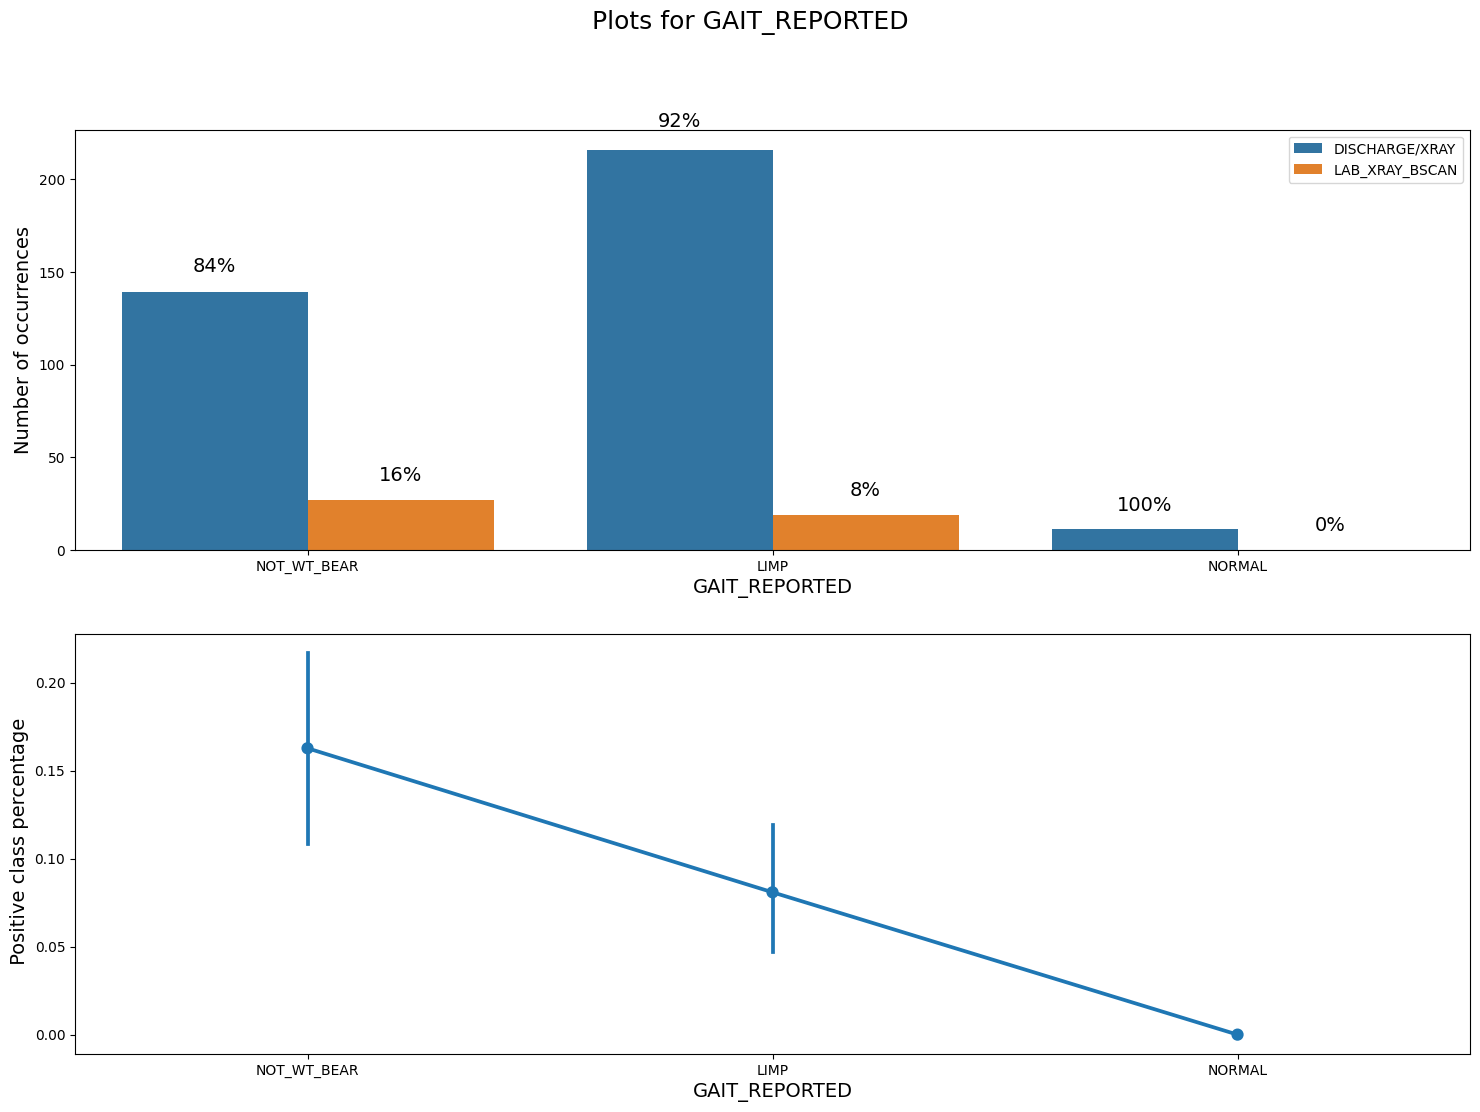

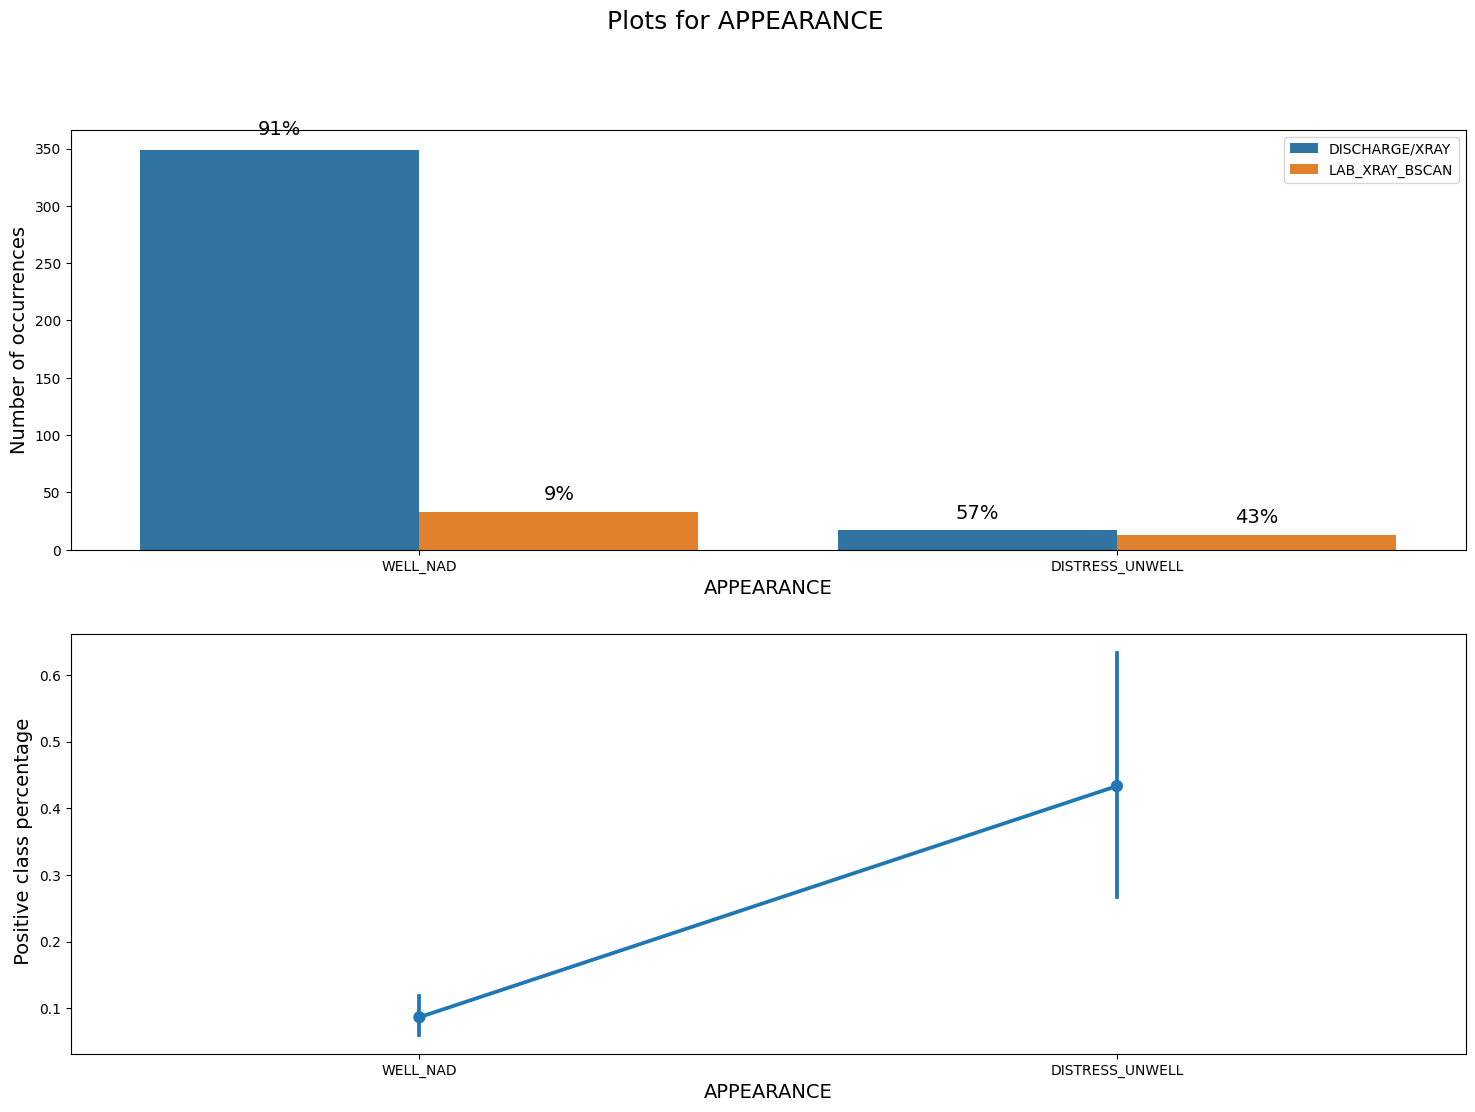

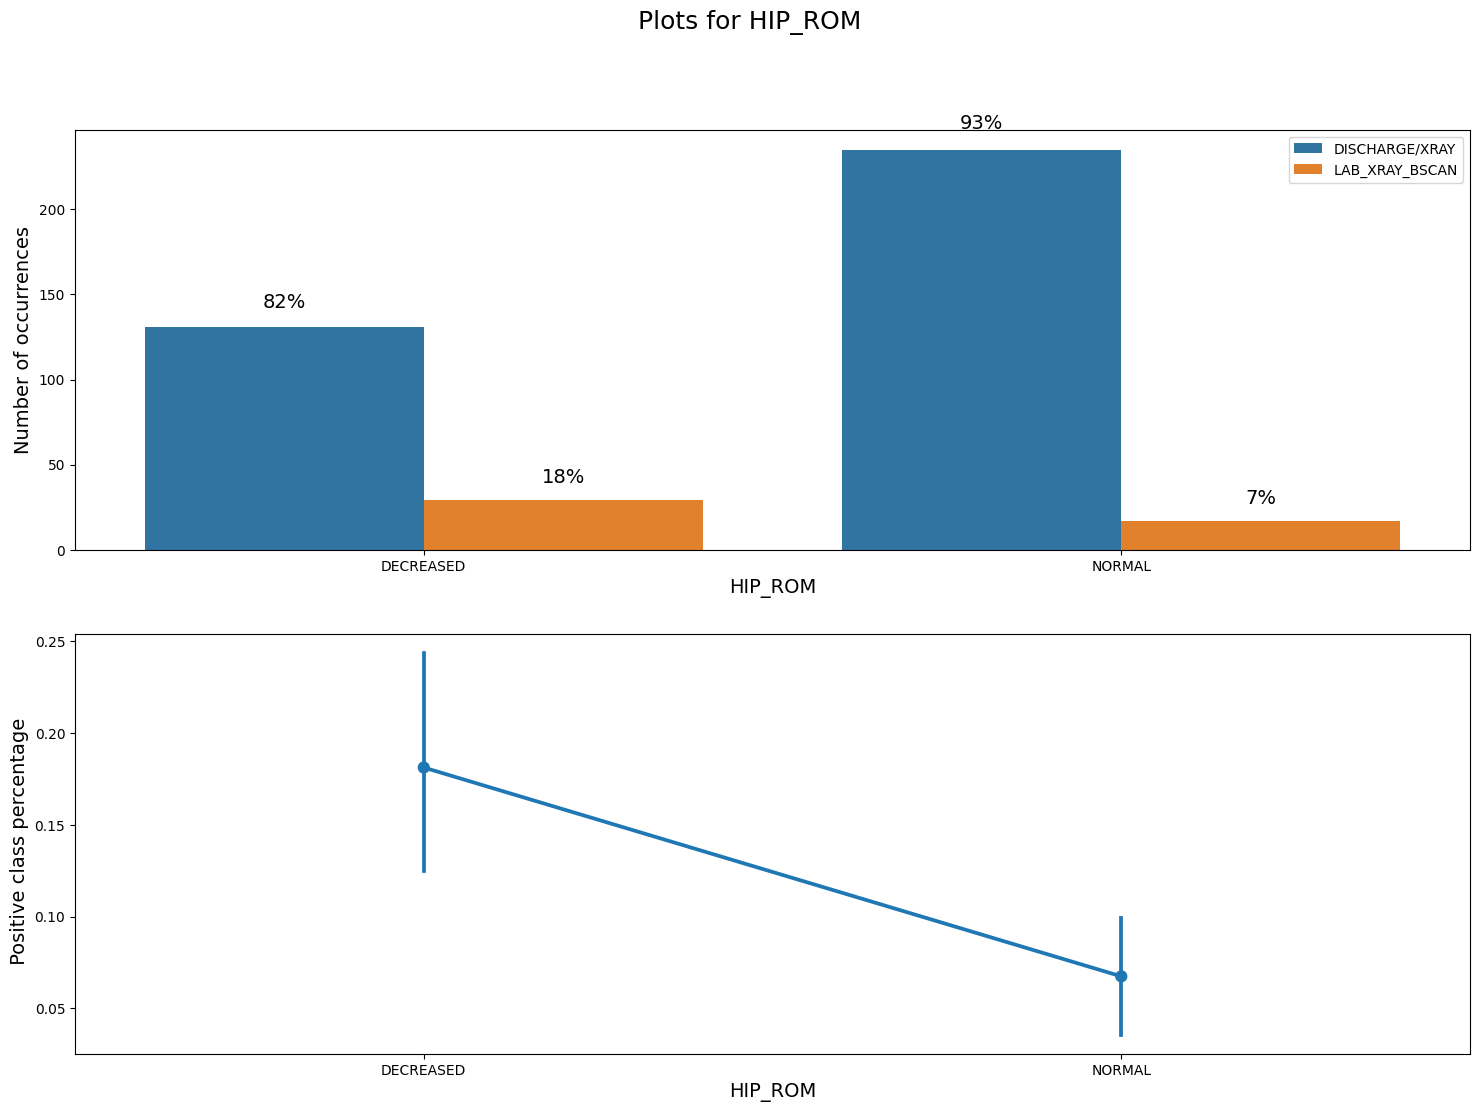

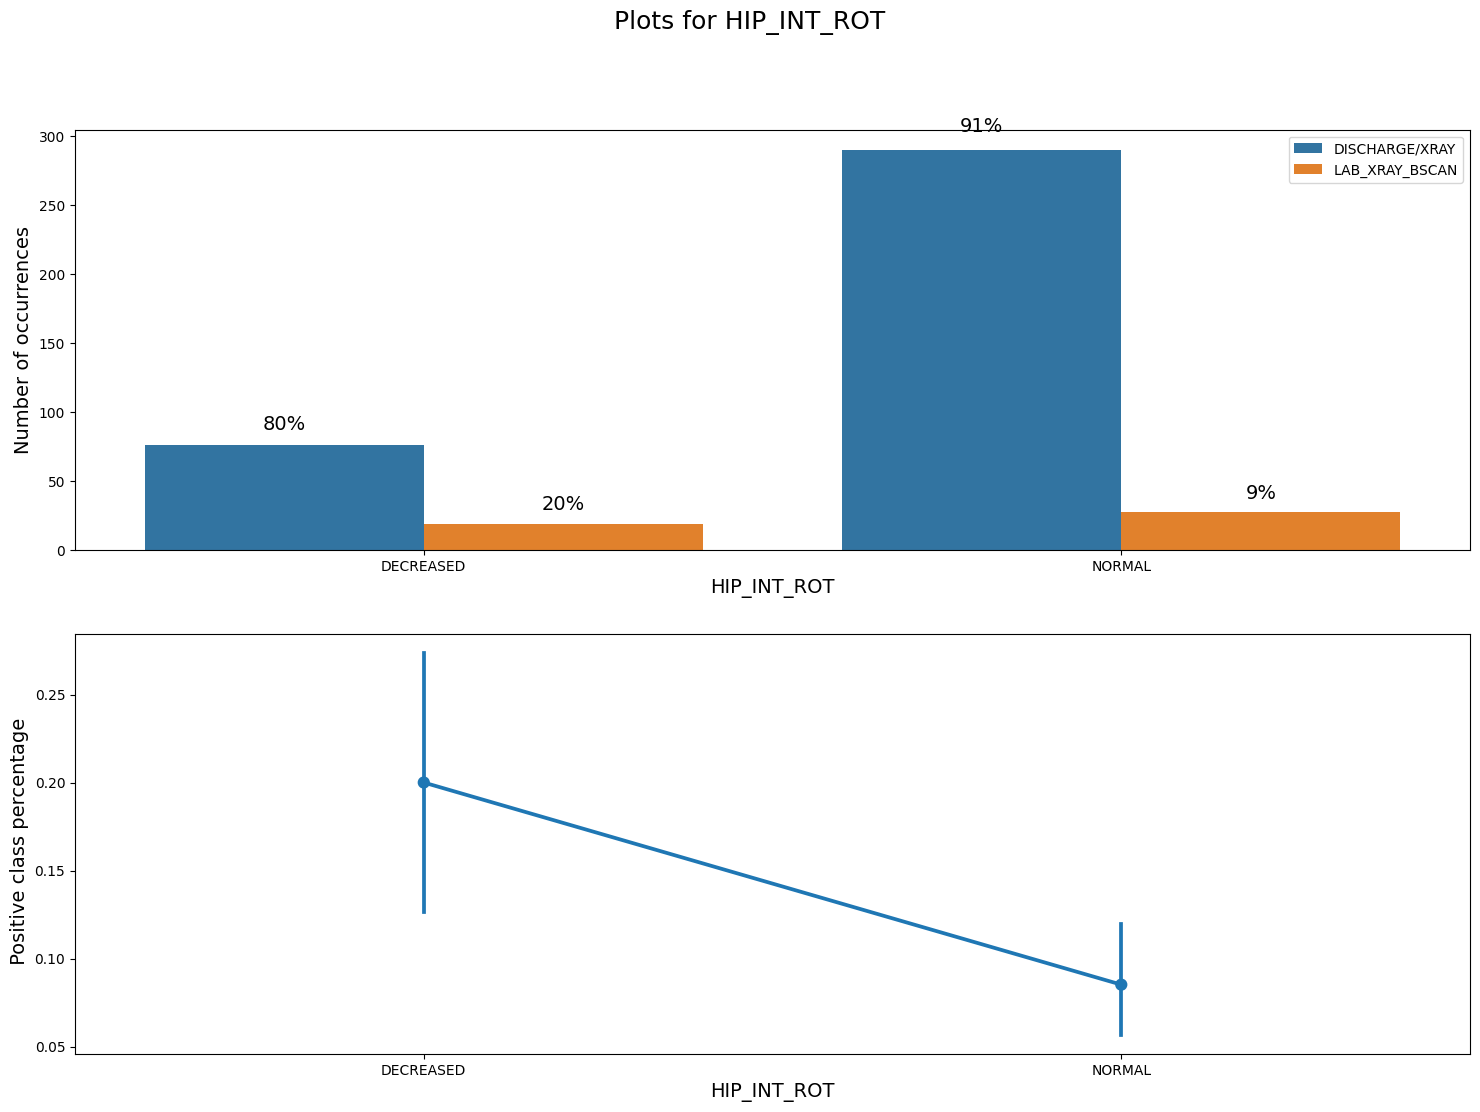

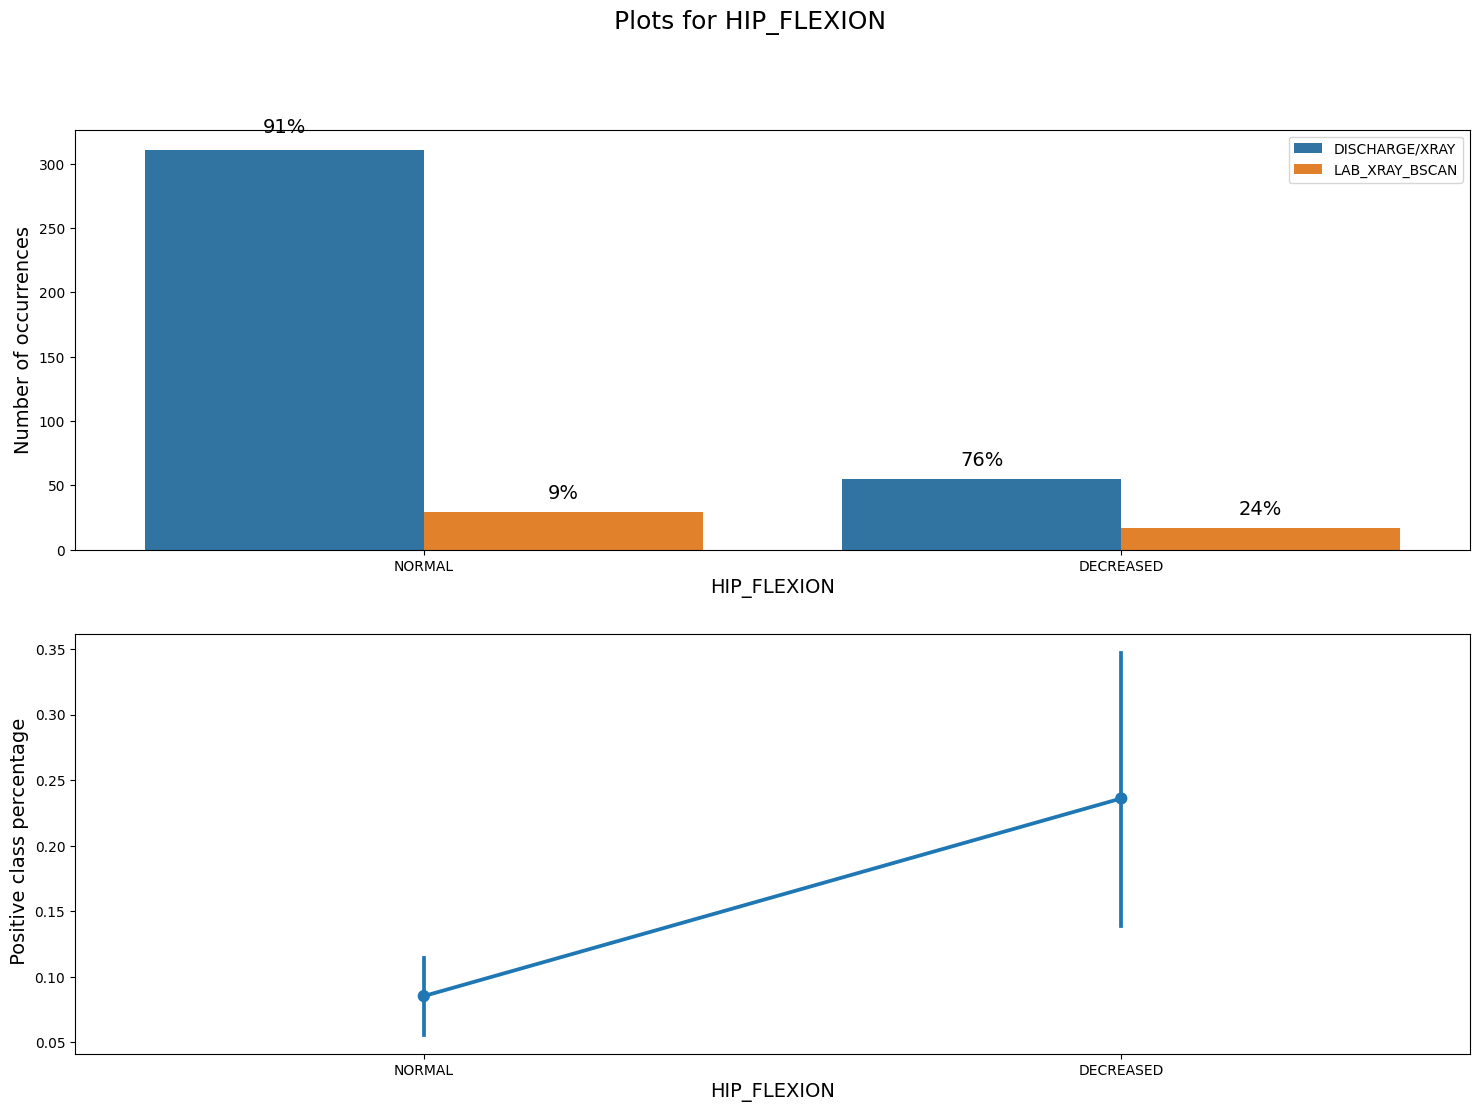

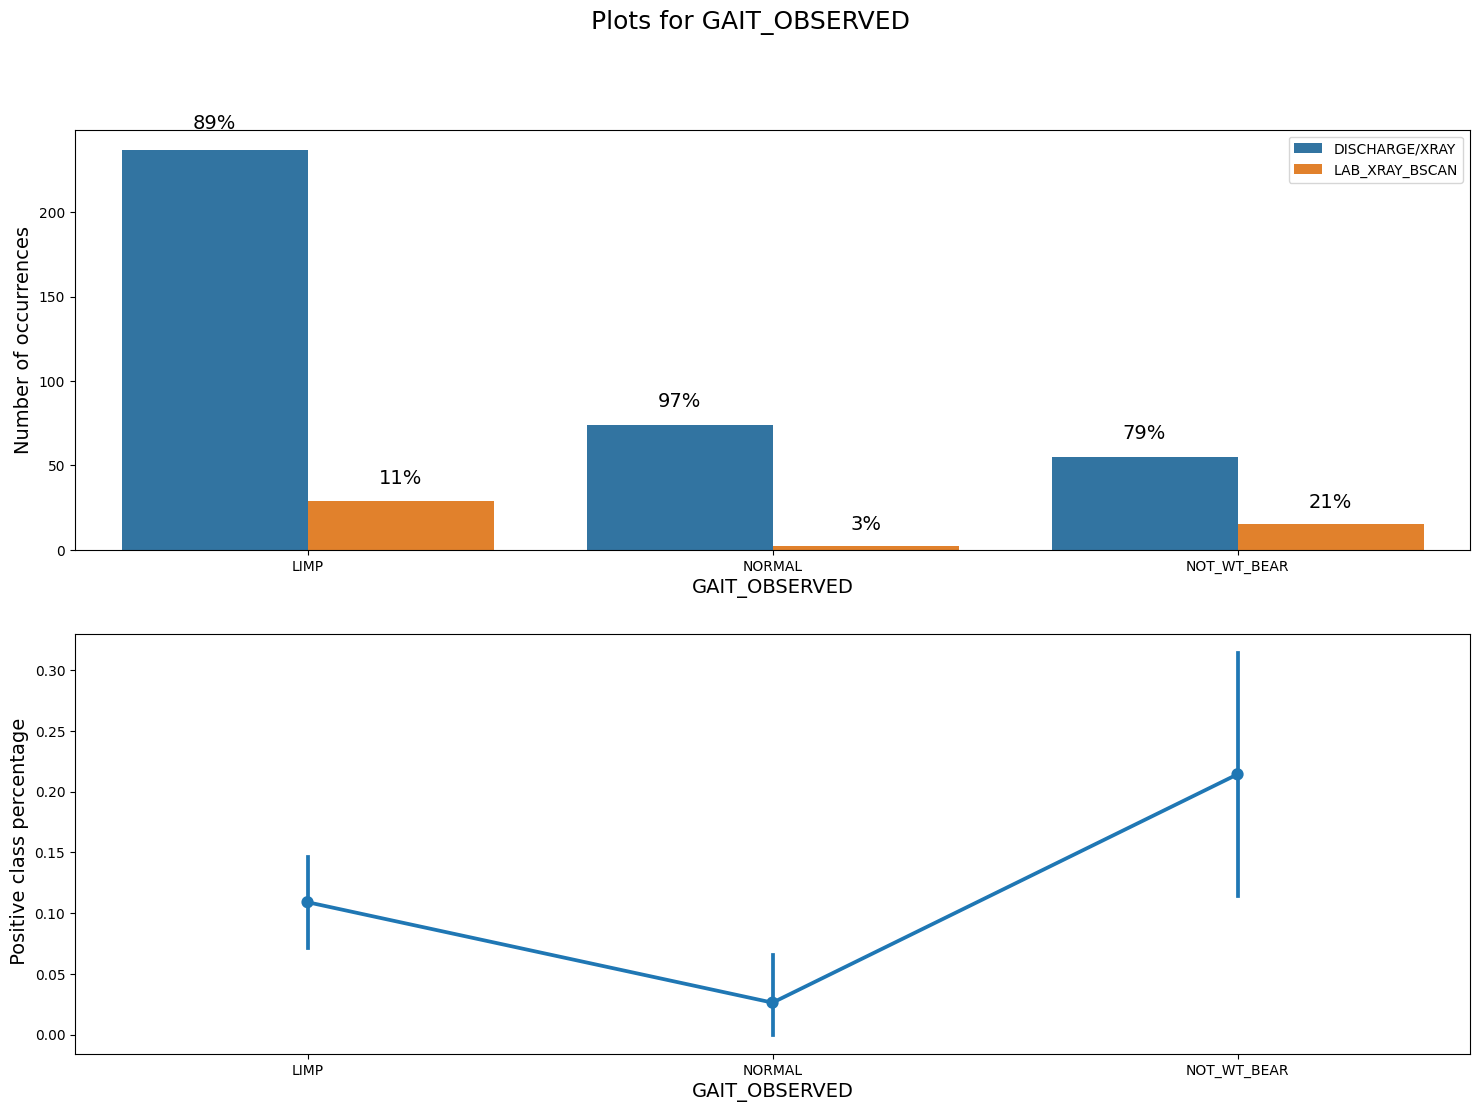

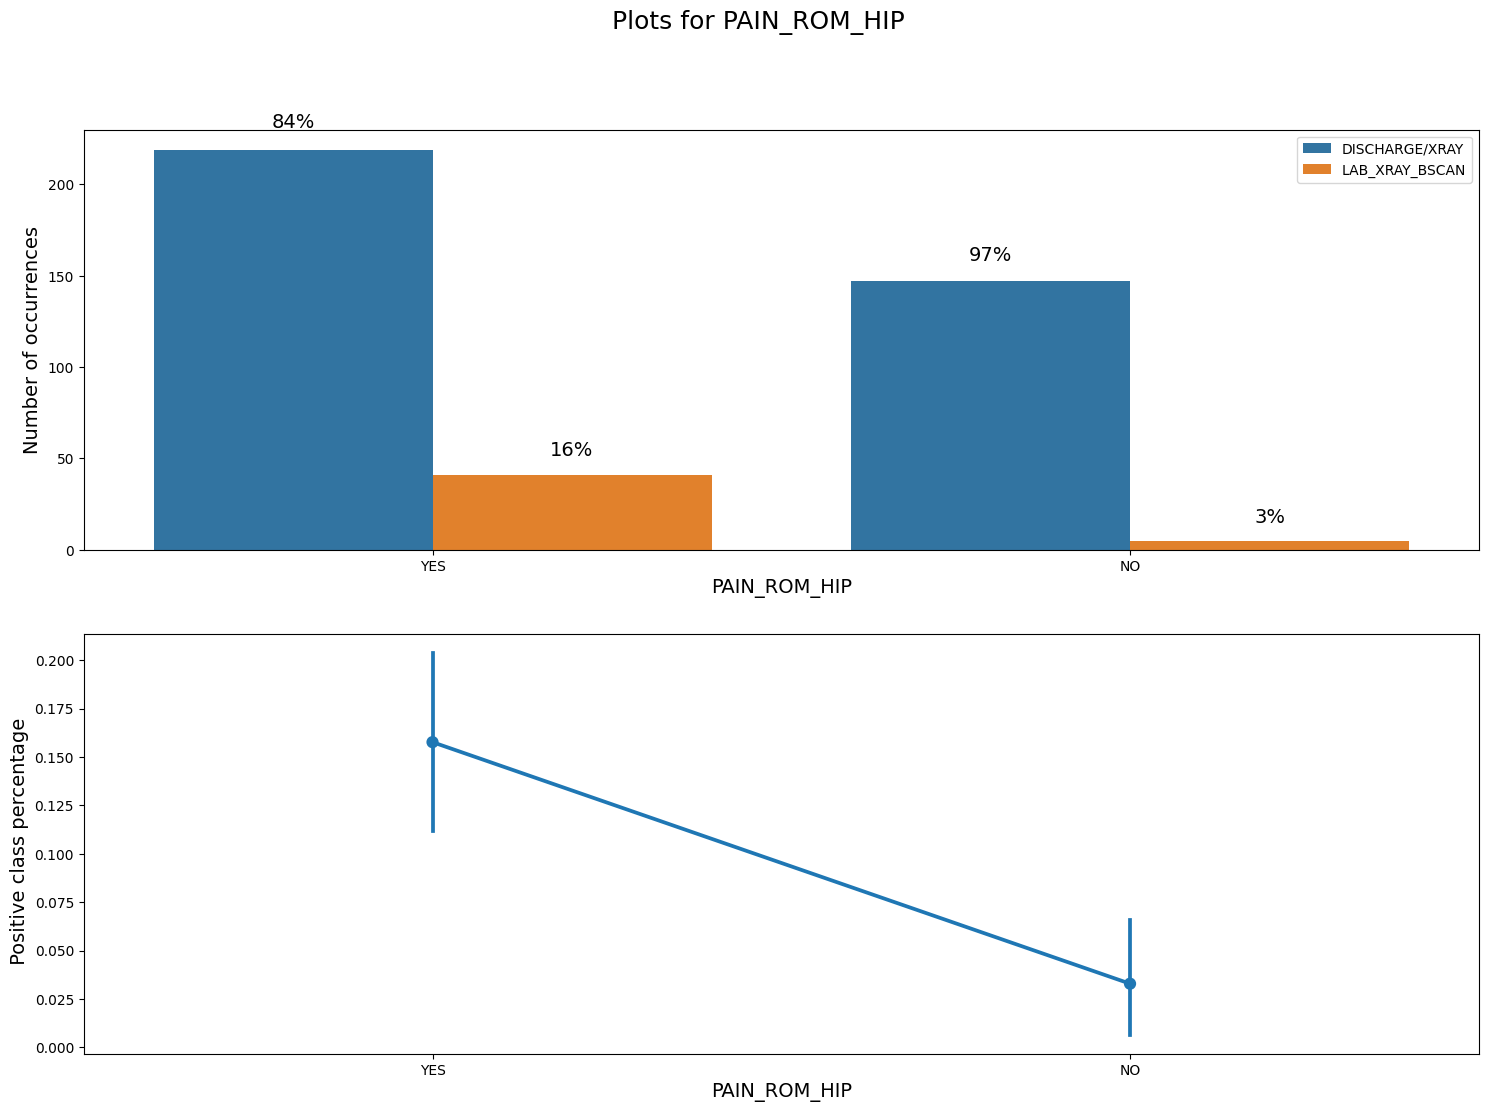

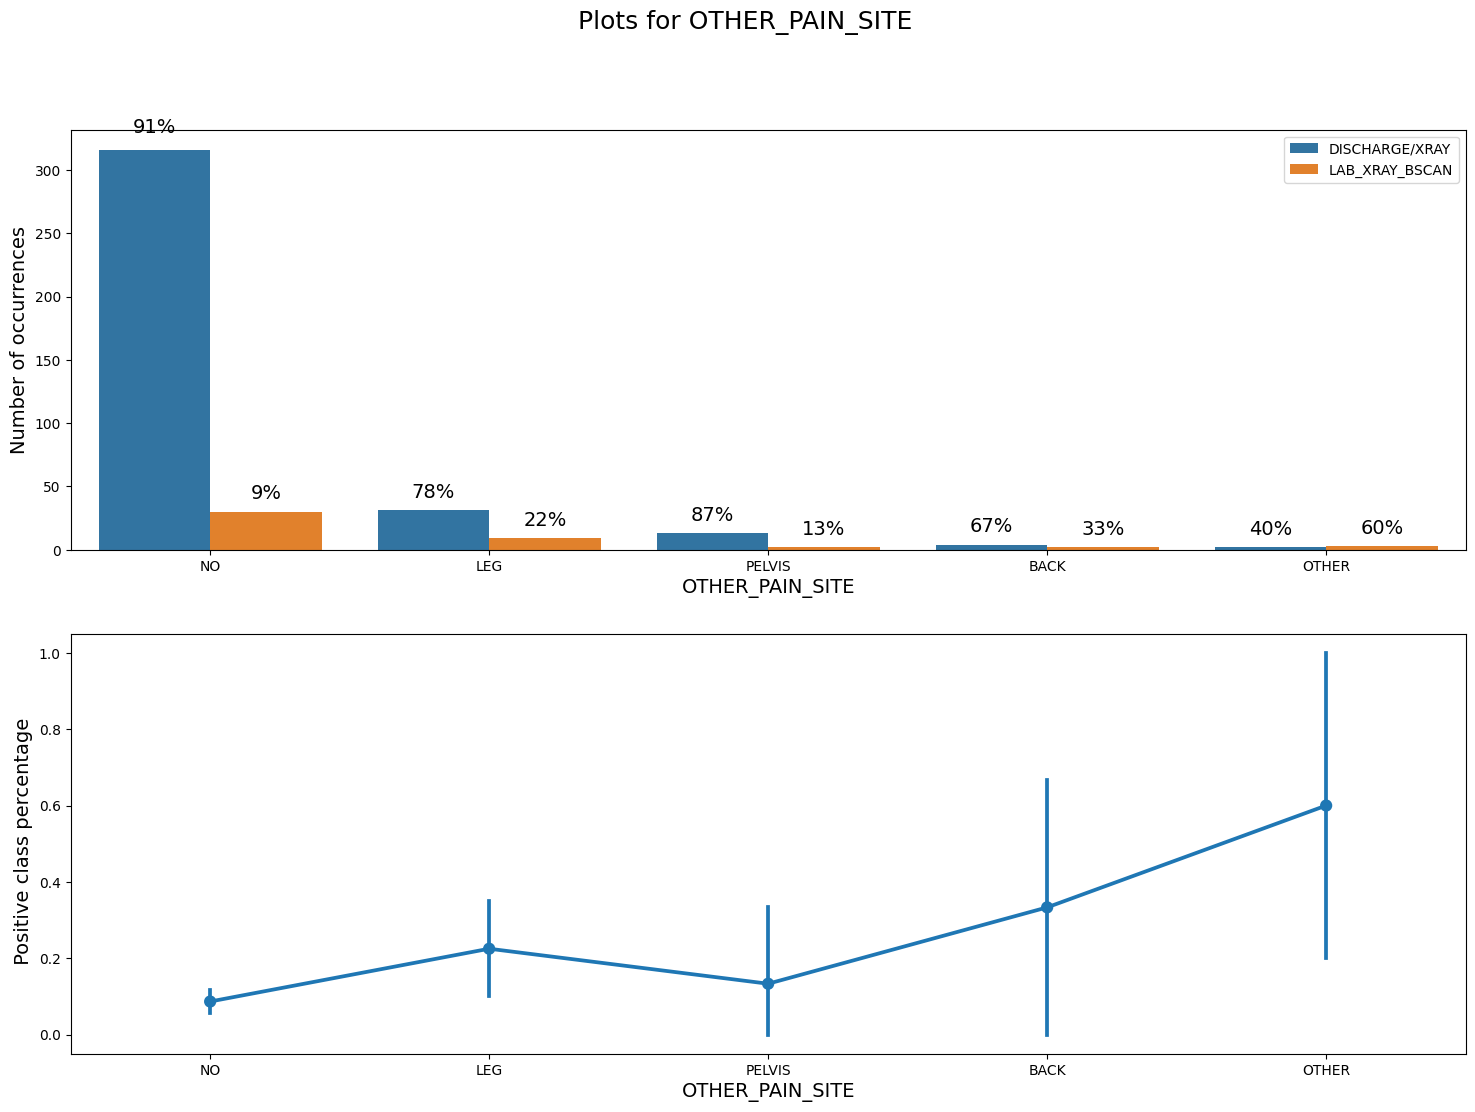

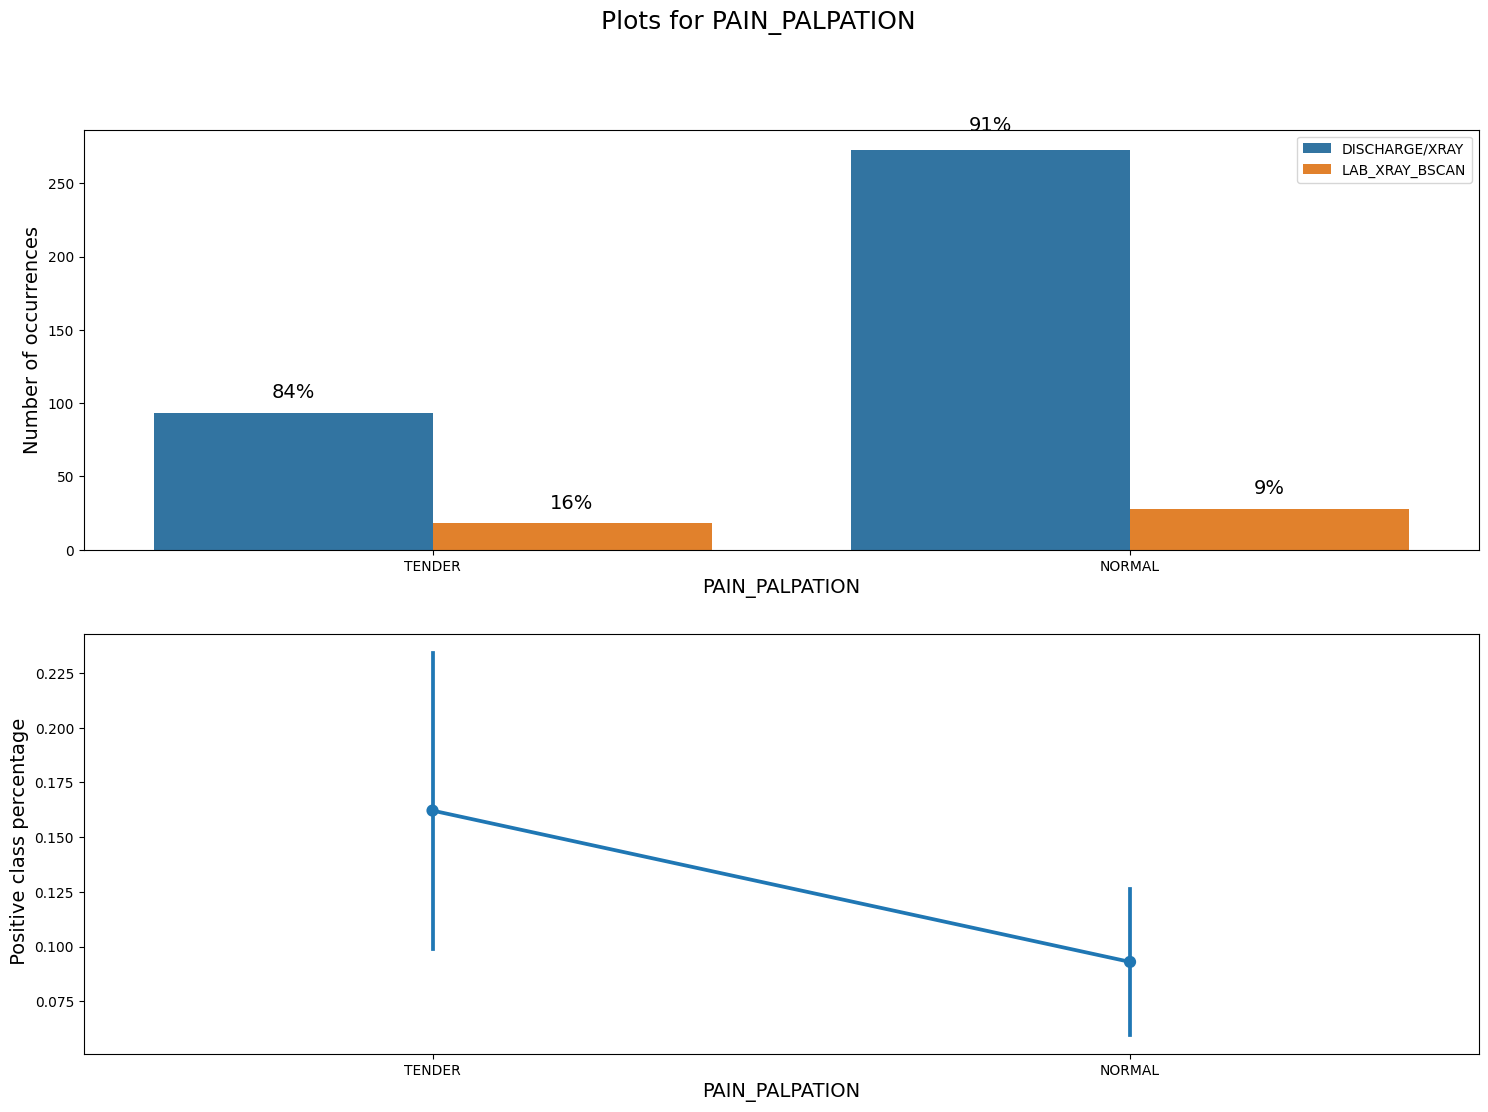

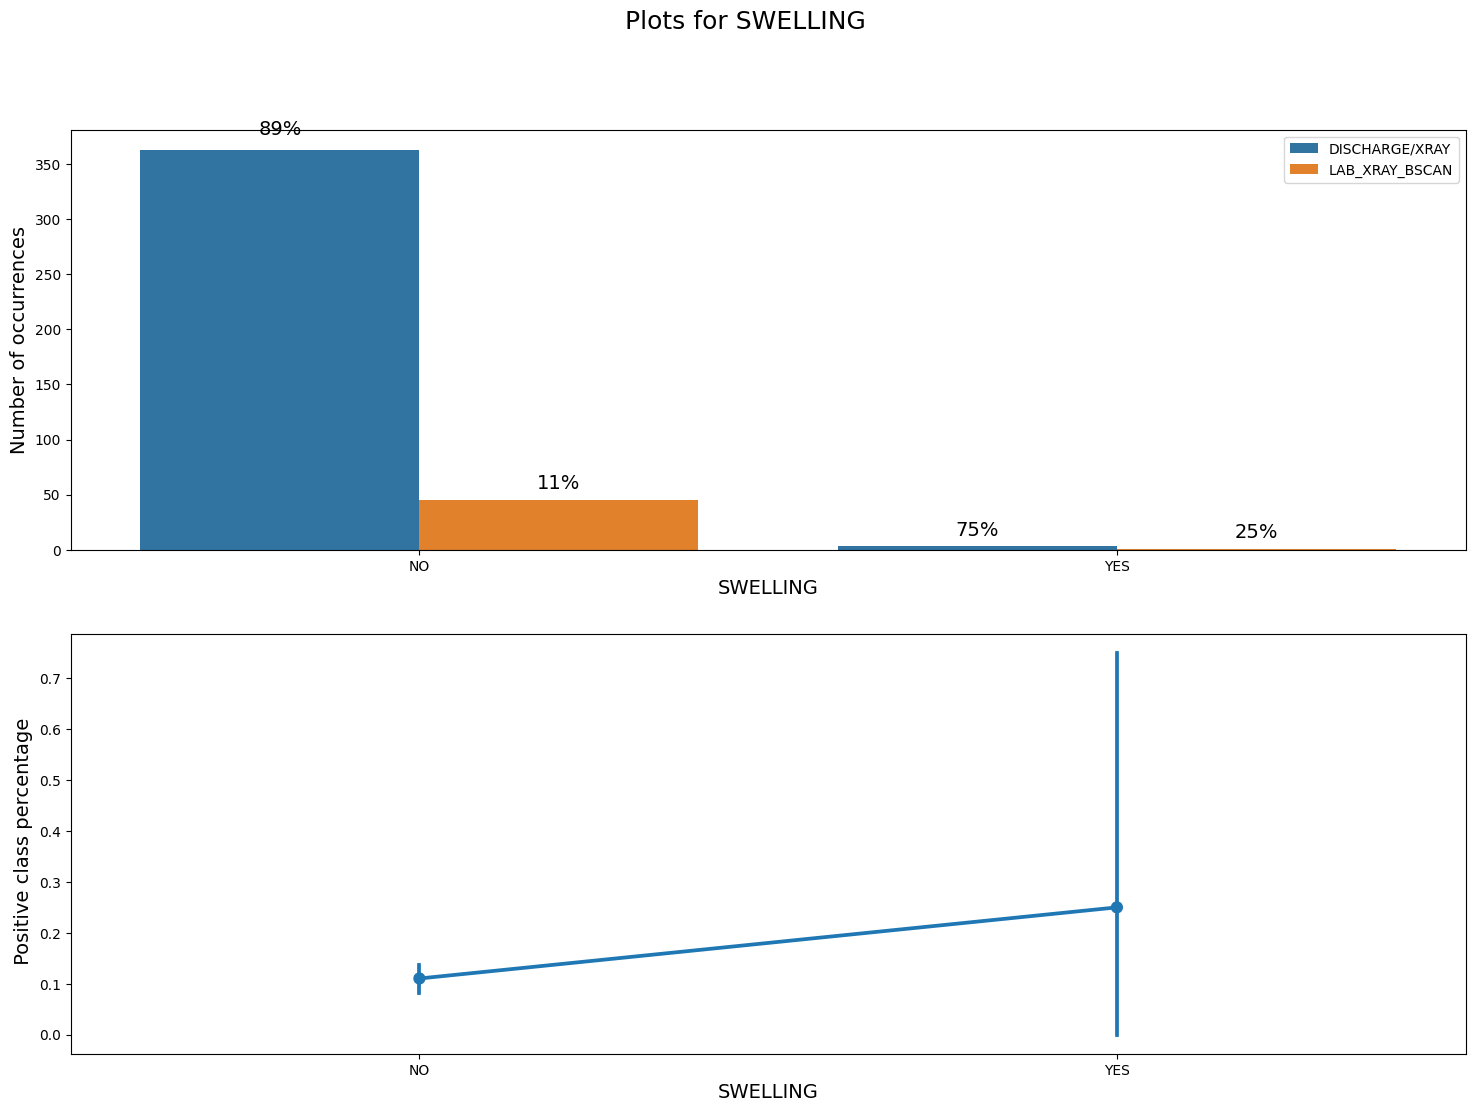

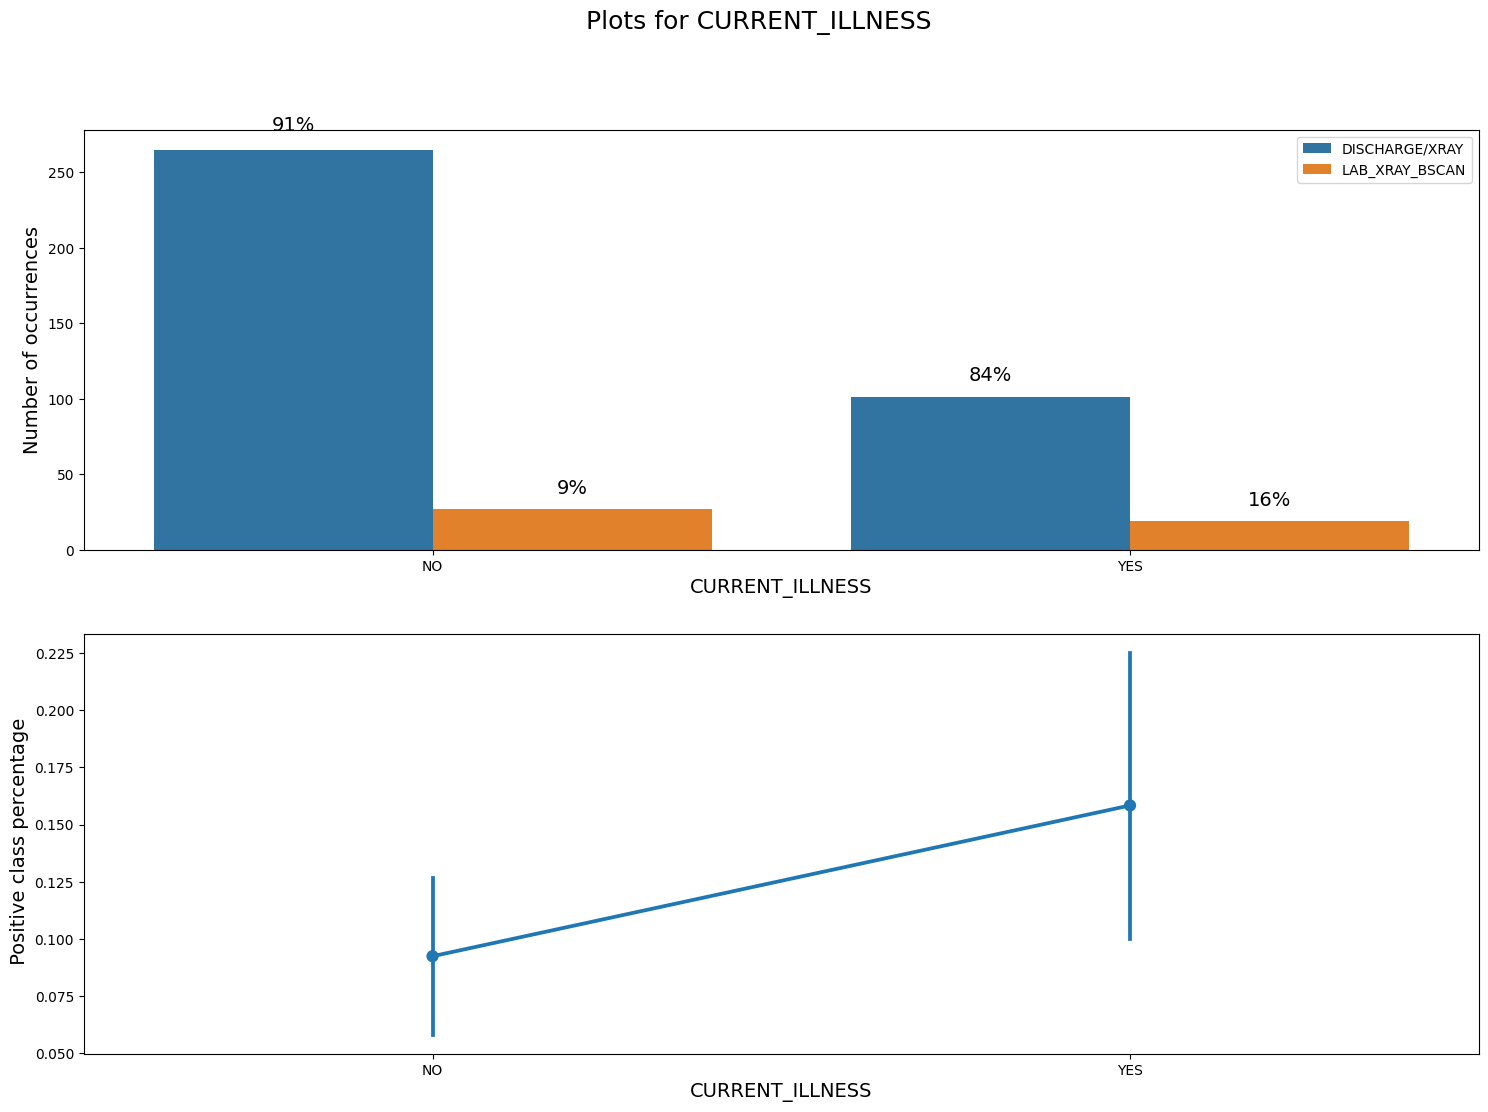

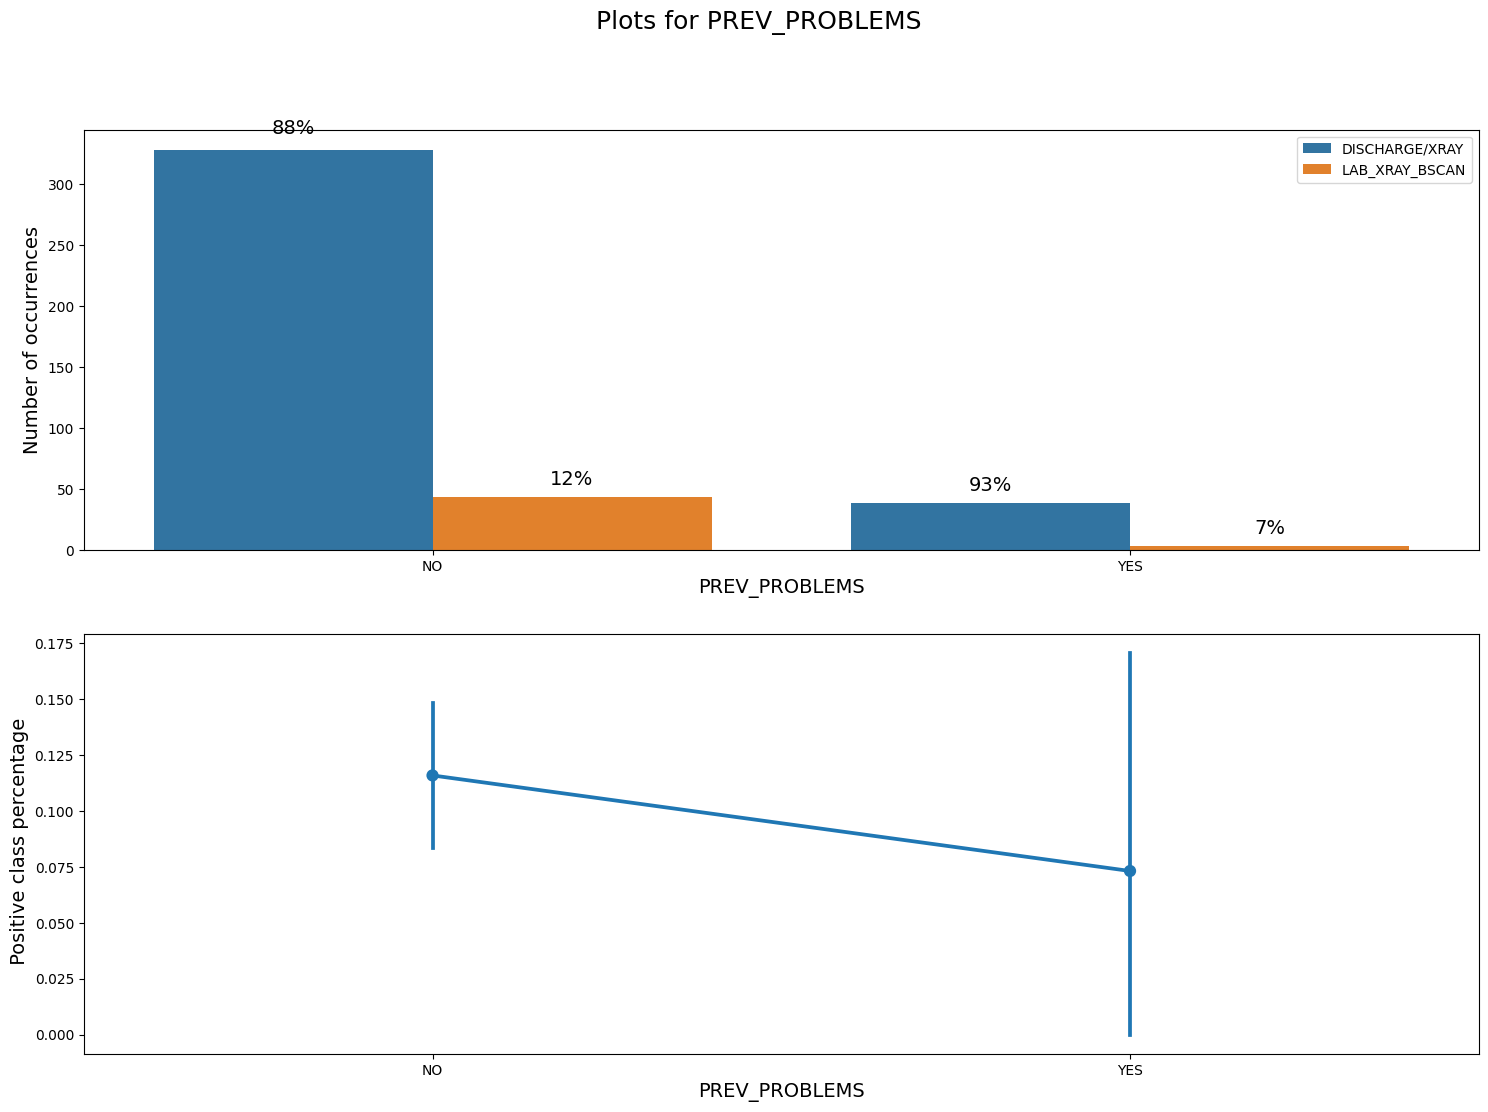

In [40]:
## Plotting nominal Categorical Features    
plot_categ(hp_retro_df, "TRIAGE", categorical_features, positive='LAB_XRAY_BSCAN')

Some values for for some features (e.g. COMPLAINT_SITE="other", SWELLING="no") are necessarly healthy.

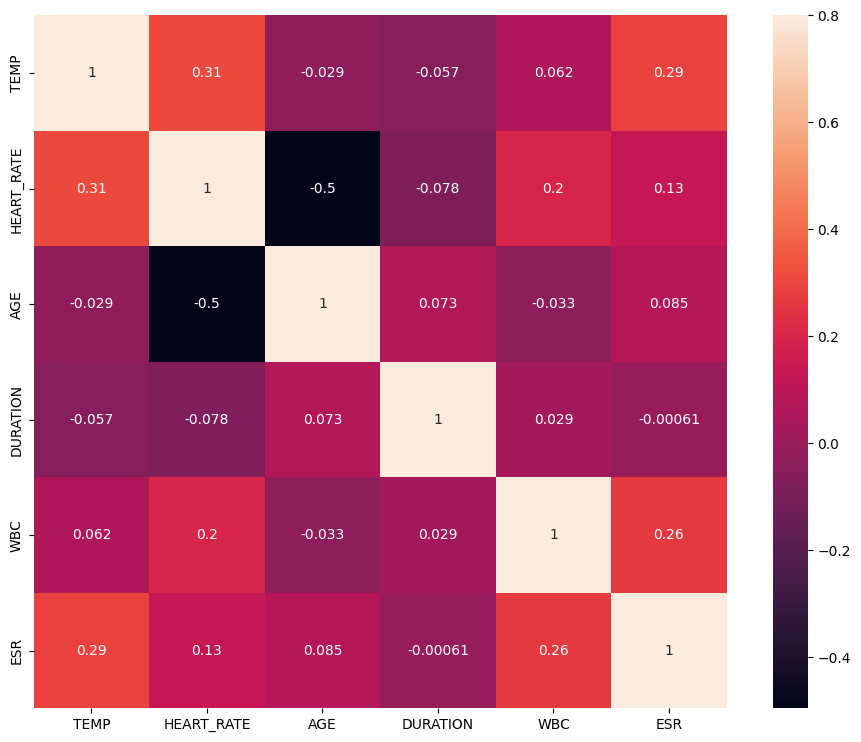

In [109]:
# Extract numerical features
cont = hp_retro_df.select_dtypes(include=np.number).columns.tolist()
# Correlation Map
corr = hp_retro_df[cont].corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, annot=True, square=True)
plt.show()

As it can be seen from above heatmap, "age" and "heart_rate", "temp" and "heart_rate" are highly correlated.

### Scaling and encoding

In [23]:
def preprocess_data(numerical_features, categorical_features, model='base'):
    """ 
    create pipeline for feature preprocessing 
    Inputs : 
        numerical_features -- list of numerical features
        categorical_features -- list of categorical features
    Outputs :
        preproc -- pipeline with feature preprocessing steps
    """
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    t = ColumnTransformer([('Scaler', numeric_transformer, numerical_features), ('OneHotEncoding', categorical_transformer, categorical_features)]) if model == 'base' \
                else ColumnTransformer([('Scaler', numeric_transformer, numerical_features)])
    return Pipeline(steps=[('preprocessor', t)])

In [110]:
# Extract text features
cats = hp_retro_df.select_dtypes(exclude=np.number).columns.tolist()
# Convert to Pandas category
for col in cats:
   hp_retro_df[col] = hp_retro_df[col].astype('category')

#  get columns names after transformation for base classifier
transf_train = preprocess_data(numerical_features, categorical_features).fit(hp_retro_df)
columns_eng = numerical_features + transf_train.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features).tolist()
print("Number of new features after one-hot-encoding:", len(columns_eng))

Number of new features after one-hot-encoding: 47


In [116]:
def train_test_model(X: np.ndarray, y: np.ndarray, classifier: str, handle_imbalance: bool=False, n_splits: int=10, n_repeats: int=5, seed: int=42):
    kfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

    if handle_imbalance:
        over = SMOTE(random_state=seed)
        under = RandomUnderSampler(random_state=seed)
        pipeline = Pipeline(steps=[('o', over), ('u', under)])
        X, y = pipeline.fit_resample(X, y)

    if classifier == "base":
        model = LogisticRegression(random_state=seed)
    else:
        model = XGBClassifier(n_estimators=100, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=3, enable_categorical=True)


    result = []
    for i, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
        X_tr, X_te, y_tr, y_te = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
        

        model.fit(X_tr, y_tr)
        y_probs = model.predict_proba(X_te)[:, 1]
        y_tr_probs = model.predict_proba(X_tr)[:, 1]


        roc_auc_val = roc_auc_score(y_te, y_probs)
        prc_auc_val = average_precision_score(y_te, y_probs)
       
        fpr, tpr, thresholds = roc_curve(y_tr, y_tr_probs)
        sensitivity, specificity = tpr, np.sort(1 - fpr)
        medium_risk_threshold = thresholds[np.argwhere(sensitivity >= 0.99)[0]]
        high_risk_threshold = thresholds[np.argwhere(specificity >= 0.9)[0]]
        
        negative_preds = (y_probs < medium_risk_threshold).astype(int)
        positive_preds = (y_probs >= high_risk_threshold).astype(int)
        moderate_preds = ((negative_preds == 0) & (positive_preds == 0)).astype(int)
        
        y_preds, y_te_reduced = [], []
        for i in range(positive_preds.shape[0]):
            if negative_preds[i] == 1:
                y_preds.append(0)
                y_te_reduced.append(y_te[i])
            elif positive_preds[i] == 1:
                y_preds.append(1)
                y_te_reduced.append(y_te[i])
        
        fp, fn, tp, tn = [0] * 4

        for i in range(len(y_te_reduced)):
            if y_te_reduced[i] == 0 and y_preds[i] == 0:
                tn += 1
            elif y_te_reduced[i] == 0 and y_preds[i] == 1:
                fp += 1
            elif y_te_reduced[i] == 1 and y_preds[i] == 0:
                fn += 1
            else:
                tp += 1
        fnr = fn / (tp + fn) if fn != 0 else 0
        fpr = fp / (fp + tn) if fp != 0 else 0
        tnr = tn / (fp + tn) if tn != 0 else 0

        negative_prop = round(sum((y_tr_probs < medium_risk_threshold).astype(int)) / len(y_tr), 2)
        positive_prop = round(sum((y_tr_probs >= high_risk_threshold).astype(int)) / len(y_tr), 2)
        
        result.append(dict(classifier=classifier, imbalanced=handle_imbalance, AUPRC=prc_auc_val, AUROC=roc_auc_val, FNR=fnr, TNR=tnr,
                            negative_prop=negative_prop, positive_prop=positive_prop))

    return result
        

In [118]:
results = []
y_train = hp_retro_df["TRIAGE"].replace({"DISCHARGE/XRAY": 0, "LAB_XRAY_BSCAN": 1}).values
runs = [("base", False), ("base", True), ("complex", False), ("complex", True)]
for classifier, handle_imbalance in runs:
    transf_train = preprocess_data(numerical_features, categorical_features, classifier).fit(hp_retro_df)
    X_train = transf_train.transform(hp_retro_df)
    res = train_test_model(X_train, y_train, classifier, handle_imbalance=handle_imbalance)
    results.extend(res)
results = pd.DataFrame(results)
results.groupby(["classifier", "imbalanced"]).agg({"AUPRC": "mean", "AUROC": "mean", "FNR": "mean", "TNR": "mean", "negative_prop": "mean", "positive_prop": "mean"}).round(3)

AUPRC  AUROC    FNR    TNR  negative_prop   
classifier imbalanced                                              
base       False       0.719  0.915  0.060  0.938          0.471  \
           True        0.962  0.967  0.016  0.930          0.392   
complex    False       0.711  0.878  0.218  0.812          0.747   
           True        0.980  0.980  0.102  1.000          0.469   

                       positive_prop  
classifier imbalanced                 
base       False               0.094  
           True                0.457  
complex    False               0.971  
           True                0.158